# Protein Function Predictions Using GNNs
## Data pre-processing, data processing, and model training (Deep Neural Network vs Deep Neural Network + Graph Sage + Deep Neural Network + Graph Attention)

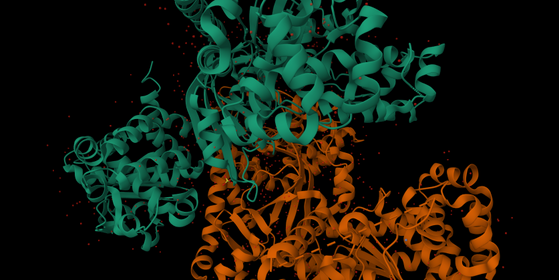

# Problem description
This project aims to predict protein functions using Graph Neural Networks (GNNs). Protein function prediction is a fundamental problem in bioinformatics, crucial for understanding biological processes and disease mechanisms. We explore a combination of different model architectures, including Deep Neural Networks (DNNs), GraphSAGE-enhanced DNNs, and Graph Attention Network (GAT)-enhanced DNNs, to leverage both sequence-derived features (ESM embeddings) from amino acid sequences and the hierarchical structure of Gene Ontology (GO) terms. The main challenges include handling the high dimensionality of protein embeddings and the sparsity of GO term annotations.

<!--- In a Markdown cell --->
<div id="mybox" style="
    color:white;
    background-color:#5642C5;
    font-size:110%;
    font-family:Verdana;
    letter-spacing:0.5px;
    display:flex;
    justify-content:center;
    border-radius:6px;
">
    <h2 style="
        padding: 2rem;
        color:white;
        text-align:center;
        margin:0 auto;
    ">
        Download packages 📦
    </h2>
</div>


In [1]:
!pip install torch==2.4.0
!pip install torch-geometric==2.4.0
!pip install biopython
!pip install obonet
!pip install networkx
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install scipy
!pip install scikit-learn
!pip install fair-esm
import torch
torch_version = str(torch.__version__)
scatter_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
sparse_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
!pip install torch-scatter -f $scatter_src
!pip install torch-sparse -f $sparse_src

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 137.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 111.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 61.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 44.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.2/176.2 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True" # avoid fragmentation
import torch
import torch_geometric
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import Bio
from Bio import SeqIO
import obonet
import gc
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import random
import esm


## Define file paths 📂
### Ensure that the files are included

In [3]:
obo_path = 'go-basic.obo' # Contains graph structure for all 3 subontologies
fasta_path = 'train_sequences.fasta' # Path to protein sequences for training split (~80k rows)
term_path = 'train_terms.tsv' # Path to term path which contains outputs (training)
taxonomy_path = 'train_taxonomy.tsv' # Path to taxonomy metadata
fasta_test_path = "testsuperset.fasta" # Path to protein sequences for training split (~200k rows)


## Constants used throughout the project

In [4]:
LARGEST_FASTA_SEQ_LEN = 8922 # During experimentation, this was the largest sequence length we were able to process (sequences are split and embeddings for each subsequence is averaged to preserve information)
ESM_EMBEDDING_DIM = 320 # Embedding dimension for esm2
PCA_TARGET_DIM = 128 # Dimensionality reduction that captures ~95% of variance
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, alphabet = esm.pretrained.esm2_t6_8M_UR50D() # Loaded model to generate embeddings (the smallest out of the esm2 (8M) family, largest is 15B)
model = model.to(device)
model = model.half()
model.eval()
batch_converter = alphabet.get_batch_converter()
embeddings_processed = True # if set to False, it will trigger a BATCH process to generate embeddings for protein sequences, if set to True, will look for the fasta_embeddings_final.csv file or fasta_embeddings_final_test.csv

Downloading: "https://dl.fbaipublicfiles.com/fair-esm/models/esm2_t6_8M_UR50D.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D.pt
Downloading: "https://dl.fbaipublicfiles.com/fair-esm/regression/esm2_t6_8M_UR50D-contact-regression.pt" to /root/.cache/torch/hub/checkpoints/esm2_t6_8M_UR50D-contact-regression.pt


In [5]:
fasta_data_train = list(SeqIO.parse(fasta_path, "fasta"))

In [6]:
len(fasta_data_train), fasta_data_train[:5]

(82404,
 [SeqRecord(seq=Seq('MRWQEMGYIFYPRKLR'), id='sp|A0A0C5B5G6|MOTSC_HUMAN', name='sp|A0A0C5B5G6|MOTSC_HUMAN', description='sp|A0A0C5B5G6|MOTSC_HUMAN Mitochondrial-derived peptide MOTS-c OS=Homo sapiens OX=9606 GN=MT-RNR1 PE=1 SV=1', dbxrefs=[]),
  SeqRecord(seq=Seq('MAGIIKKQILKHLSRFTKNLSPDKINLSTLKGEGELKNLELDEEVLQNMLDLPT...TVE'), id='sp|A0JNW5|BLT3B_HUMAN', name='sp|A0JNW5|BLT3B_HUMAN', description='sp|A0JNW5|BLT3B_HUMAN Bridge-like lipid transfer protein family member 3B OS=Homo sapiens OX=9606 GN=BLTP3B PE=1 SV=2', dbxrefs=[]),
  SeqRecord(seq=Seq('MVAEVCSMPAASAVKKPFDLRSKMGKWCHHRFPCCRGSGKSNMGTSGDHDDSFM...TSI'), id='sp|A0JP26|POTB3_HUMAN', name='sp|A0JP26|POTB3_HUMAN', description='sp|A0JP26|POTB3_HUMAN POTE ankyrin domain family member B3 OS=Homo sapiens OX=9606 GN=POTEB3 PE=1 SV=2', dbxrefs=[]),
  SeqRecord(seq=Seq('MPGWFKKAWYGLASLLSFSSFILIIVALVVPHWLSGKILCQTGVDLVNATDREL...ILY'), id='sp|A0PK11|CLRN2_HUMAN', name='sp|A0PK11|CLRN2_HUMAN', description='sp|A0PK11|CLRN2_HUMAN Clarin-2

In [7]:
fasta_data_test = list(SeqIO.parse(fasta_test_path, "fasta"))

In [8]:
len(fasta_data_test), fasta_data_test[:5]

(224309,
 [SeqRecord(seq=Seq('MRWQEMGYIFYPRKLR'), id='A0A0C5B5G6', name='A0A0C5B5G6', description='A0A0C5B5G6 9606', dbxrefs=[]),
  SeqRecord(seq=Seq('MLLLLLLLLLLPPLVLRVAASRCLHDETQKSVSLLRPPFSQLPSKSRSSSLTLP...REV'), id='A0A1B0GTW7', name='A0A1B0GTW7', description='A0A1B0GTW7 9606', dbxrefs=[]),
  SeqRecord(seq=Seq('MAGIIKKQILKHLSRFTKNLSPDKINLSTLKGEGELKNLELDEEVLQNMLDLPT...TVE'), id='A0JNW5', name='A0JNW5', description='A0JNW5 9606', dbxrefs=[]),
  SeqRecord(seq=Seq('MVAEVCSMPAASAVKKPFDLRSKMGKWCHHRFPCCRGSGKSNMGTSGDHDDSFM...TSI'), id='A0JP26', name='A0JP26', description='A0JP26 9606', dbxrefs=[]),
  SeqRecord(seq=Seq('MPGWFKKAWYGLASLLSFSSFILIIVALVVPHWLSGKILCQTGVDLVNATDREL...ILY'), id='A0PK11', name='A0PK11', description='A0PK11 9606', dbxrefs=[])])

In [9]:
term_df = pd.read_csv(term_path, sep='\t')
term_df.head(), len(term_df["term"].unique()), term_df.count()

(  EntryID        term aspect
 0  Q5W0B1  GO:0000785      C
 1  Q5W0B1  GO:0004842      F
 2  Q5W0B1  GO:0051865      P
 3  Q5W0B1  GO:0006275      P
 4  Q5W0B1  GO:0006513      P,
 26125,
 EntryID    537027
 term       537027
 aspect     537027
 dtype: int64)

In [10]:
taxonomy_df = pd.read_csv(taxonomy_path, sep='\t')
taxonomy_df.head()

,A0A0C5B5G6,9606
0,A0JNW5,9606
1,A0JP26,9606
2,A0PK11,9606
3,A1A4S6,9606
4,A1A519,9606


# Data Preprocessing 🖨️
## We will walk through the setup for our initial experiments (training data for model selection) which focused on 200 top most frequent terms per subontology, this was done because the data is incredibly sparse, initial attempts were made with simpler architectures to handle all 26k terms (multi-label classification) but results were poor. These experiments which used a subset of the terms to predict allowed us to find architectures that can learn relatively well the problem at hand (DNN, GSage + DNN, and GAT + DNN were architectures tested).

## Helper functions for reading data, generating embeddings in a batch fashion and performing PCA for dimensionality reduction (embeddings are expensive from a memory perspective for our colab setups).

**The embedding functions are only called if**

In [11]:


def get_processed_fasta_df(fasta_data:list) -> pd.DataFrame:
    """
    Helper function to process sequences. They include the EntryID within their id,
    allowing us to perform a join with the final dataset.
    """
    fasta_dict_list = []
    for fasta_seq in fasta_data:
        entry = fasta_seq.id.split('|')[1] if '|' in fasta_seq.id else fasta_seq.id
        fasta_dict_list.append({
                "EntryID": entry,
                "fasta_sequence": str(fasta_seq.seq)
            })

    return pd.DataFrame(fasta_dict_list)


# NOTE:
def generate_protein_embeddings_esm_batch(seq_df, seq_col='Sequence', entryid_col='EntryID', target_dim=16, batch_size=1, use_fp16=True):
    """
    Memory-optimized ESM embedding generation for proteins.
    Processes small batches and moves embeddings to CPU immediately.
    Logic is included to handle very long sequences by splitting them, calculating
    the embeddings for each split and averaging them out (preserving information).
    """
    sequences = seq_df[seq_col].tolist()
    entry_ids = seq_df[entryid_col].tolist()
    print(f"sequences: {len(sequences)} entry_ids {len(entry_ids)}")

    all_embeddings = []
    dtype = torch.float16 if use_fp16 else torch.float32
    for i in range(0, len(sequences), batch_size):
        try:
            batch_seqs = sequences[i:i+batch_size]
            batch_labels = entry_ids[i:i+batch_size]
            # SEQUENCE IS TOO LARGE, SPLIT
            if len(batch_seqs[0]) > LARGEST_FASTA_SEQ_LEN:
                print(f"length of batch seqs is: {len(batch_seqs[0])}")
                curr_seq = batch_seqs[0]
                embeddings_list = []
                for i in range(0, len( batch_seqs[0]), LARGEST_FASTA_SEQ_LEN):
                  curr_seq = batch_seqs[0][i:i+LARGEST_FASTA_SEQ_LEN]
                  curr_seq_embedding = get_sequence_embedding_esm(batch_labels, [curr_seq], dtype)
                  embeddings_list.append(curr_seq_embedding)
                # Average the embeddings_list since the long sequences were broken down into smaller chunks
                seq_embeddings = np.mean(embeddings_list, axis=0)

            else:
              seq_embeddings = get_sequence_embedding_esm(batch_labels, batch_seqs, dtype)
            all_embeddings.append(seq_embeddings)
            del seq_embeddings
        except Exception as e:
            print(len(batch_seqs[0]))
            print(batch_seqs)

    raw_embeddings = np.vstack(all_embeddings)
    # Mitigate memory constraints
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    torch.cuda.reset_peak_memory_stats()

    # Save protein columns
    col_names = [f"prot_emb_{i}" for i in range(ESM_EMBEDDING_DIM)]
    emb_df = pd.DataFrame(raw_embeddings, index=entry_ids, columns=col_names)
    emb_df.index.name = entryid_col

    return emb_df


def get_sequence_embedding_esm(batch_labels, batch_seqs, dtype):
    '''
    Helper function to generate embeddings for a batch of sequences,
    '''
    batch_data = [(label, seq) for label, seq in zip(batch_labels, batch_seqs)]
    _, _, batch_tokens = batch_converter(batch_data)
    batch_tokens = batch_tokens.to(device)
    with torch.no_grad():
      with torch.autocast(device_type="cuda", dtype=dtype):
          results = model(batch_tokens, repr_layers=[model.num_layers], return_contacts=False)
          token_embeddings = results["representations"][model.num_layers]  # (B, L, D)
          # Mean pool over sequence length
          attention_mask = batch_tokens != alphabet.padding_idx
          masked_embeddings = token_embeddings * attention_mask.unsqueeze(-1)
          seq_lengths = attention_mask.sum(dim=1).unsqueeze(-1)
          seq_embeddings = (masked_embeddings.sum(dim=1) / seq_lengths).cpu().float().numpy()
          del batch_tokens, token_embeddings, masked_embeddings, results, attention_mask
          return seq_embeddings


def apply_pca_to_esm_embeddings(esm_embeddings_df:pd.DataFrame, target_dim=16, include_plot=True):
    '''
    Helper method for applying PCA to ESM embeddings. In addition, a plot is generated.
    '''
    emb_cols = [c for c in esm_embeddings_df.columns if c.startswith("prot_emb")]

    tensor_list = [
        torch.tensor(row[emb_cols].values.astype("float16"), dtype=torch.float16)
        for _, row in esm_embeddings_df.iterrows()
    ]
    pca = PCA(n_components=PCA_TARGET_DIM)
    tensor_list_transformed = pca.fit_transform(tensor_list)
    if include_plot:
      plt.plot(np.cumsum(pca.explained_variance_ratio_))
      plt.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
      plt.xlabel('Number of Components')
      plt.ylabel('Cumulative Explained Variance')
      save_path = 'pca_variance_plot.png'
      plt.savefig(save_path, dpi=300)

    # Intialize dictionary where we use EntryID for joining with all the other data
    embeddings_dict = { "EntryID": [] }

    for i in range(PCA_TARGET_DIM):
        embeddings_dict[f"emb_{i}"] =  []

    # Append EntryID's and embeddings to the dictionary for the dataframe
    for i, r in enumerate(tensor_list_transformed):
        curr_entry_id = esm_embeddings_df["EntryID"][i]
        embeddings_dict["EntryID"].append(curr_entry_id)
        for j in range(PCA_TARGET_DIM):
            embeddings_dict[f"emb_{j}"].append(r[j])

    pca_embeddings_df = pd.DataFrame(embeddings_dict)
    return pca_embeddings_df




## Obtain merged dataset (taxonomy, terms, graph and protein sequence embeddings)

537027

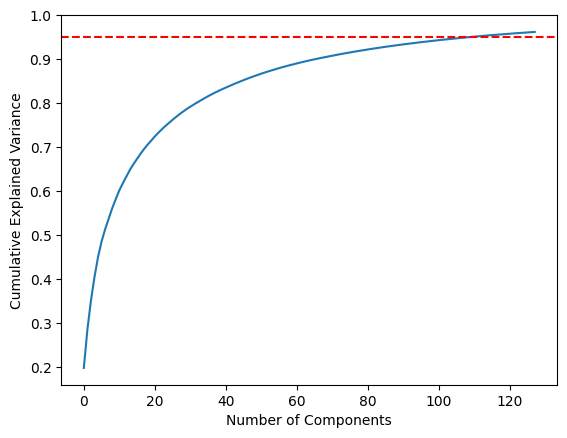

In [12]:
file_name = "fasta_embeddings_final.csv"

def get_merged_df_full(file_name, fasta_file, batch_size=250, embeddings_processed=True):
    """
    file_name: name of the .csv file we want to read/generate embeddings using a batch strategy
    fasta_file: path of the fasta file.
    batch_size: number of sequences to process at a time.
    embeddings_processed: if set to True will attempt to read the file directly, if set to False it will start
    the batch process to generate embeddings for the protein sequences.

    Merge term.tsv, fasta data, taxonomy data as well as nodes in the obo graph with the goal of creating a centralized dataset.
    A batched approach is used in order to avoid losing progress and 250 embeddings are written to the file_name variable
    in append only mode.

    Once embeddings are processed, PCA is performed with 128 dimensions (320 are the embeddings for ESM2 8M) while preserving
    95% of the variance, reducing the dimensionality of the embeddings.

    The output the merged dataframe, the graph as well as the fasta protein sequences embeddings as a 3 length tuple.
    """
    term_df = pd.read_csv(term_path, sep='\t')
    term_df = term_df
    taxonomy_df = pd.read_csv(taxonomy_path, sep='\t', names=['EntryID', 'taxonomyID'])
    fasta_data = list(SeqIO.parse(fasta_file, "fasta"))

    entry_ids = list(term_df['EntryID'])
    all_batches = []
    fasta_data_processed = get_processed_fasta_df(fasta_data)
    if not embeddings_processed:
      for i in range(0, len(fasta_data_processed), batch_size):
          total_processed = i
          print(f"Total processed: {total_processed}, {i//batch_size} batch")
          fasta_df_batch = fasta_data_processed[i:i+batch_size]
          fasta_emb_df_batch = generate_protein_embeddings_esm_batch(
              fasta_df_batch,
              "fasta_sequence"
          )

          if os.path.exists(file_name):

              fasta_emb_df_batch.to_csv(file_name, mode='a', header=False)
          else:
              fasta_emb_df_batch.to_csv(file_name, mode='w', header=True)

    full_df = pd.read_csv(file_name)
    fasta_emb_df = apply_pca_to_esm_embeddings(full_df)

    merged_df = pd.merge(term_df, fasta_emb_df, on="EntryID", how='left')
    merged_df = pd.merge(merged_df, taxonomy_df, on="EntryID", how="left")
    graph = obonet.read_obo(obo_path)

    return merged_df, graph, fasta_emb_df

protein_function_df, graph, fasta_emb_df = get_merged_df_full(file_name, fasta_test_path, embeddings_processed=embeddings_processed)
len(protein_function_df)

### Load test embeddings

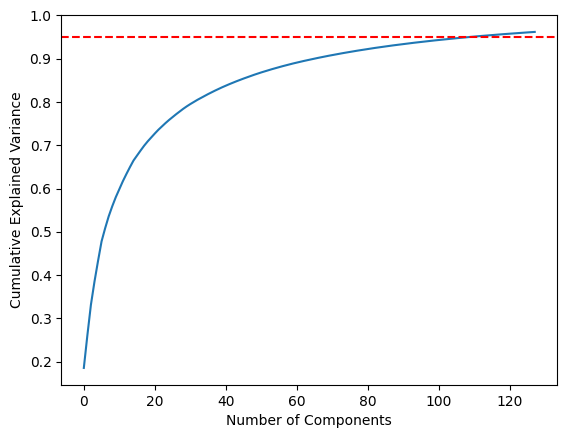

In [15]:
file_name = "fasta_embeddings_final_test.csv"
protein_function_df_test, graph_df_test, fasta_emb_df_test = get_merged_df_full(file_name, fasta_test_path, embeddings_processed=embeddings_processed)

In [16]:
fasta_emb_df_test.head(), fasta_emb_df_test.count()

(      EntryID     emb_0     emb_1     emb_2     emb_3     emb_4     emb_5  \
 0  A0A0C5B5G6 -0.853958  0.384699  1.489090 -0.446925  0.230465 -0.345550   
 1  A0A1B0GTW7 -0.339077  0.781572  0.828862  0.557844  0.652954  0.085765   
 2      A0JNW5 -0.580322  0.705734  0.094666 -0.765680  0.165853  0.186274   
 3      A0JP26  1.047370  1.029549 -0.173355 -0.592542 -0.073731 -0.088709   
 4      A0PK11 -0.857439 -0.325680  0.836646  0.281238 -0.035839  0.226356   
 
       emb_6     emb_7     emb_8  ...   emb_118   emb_119   emb_120   emb_121  \
 0  1.158714  0.456279 -0.363239  ...  0.068873 -0.052596  0.025617  0.032358   
 1 -0.259008  0.000970 -0.144042  ...  0.016446 -0.003735  0.025058 -0.008659   
 2 -0.385446  0.047615 -0.109850  ... -0.030819 -0.013119  0.019817 -0.145413   
 3  0.245232  0.501021  0.528633  ... -0.011440 -0.005949 -0.025932  0.025948   
 4 -0.036998  0.329869  0.024597  ... -0.051663 -0.024171 -0.031083  0.034767   
 
     emb_122   emb_123   emb_124   emb_125

In [17]:
protein_function_df_test.head()

,EntryID,term,aspect,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,...,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127,taxonomyID
0,Q5W0B1,GO:0000785,C,-0.077293,1.13398,-0.079276,-0.950351,0.19345,0.11233,-0.270555,...,-0.022169,0.05236,0.02772,0.034324,0.017426,0.003614,0.030384,-0.00783,-0.008808,9606
1,Q5W0B1,GO:0004842,F,-0.077293,1.13398,-0.079276,-0.950351,0.19345,0.11233,-0.270555,...,-0.022169,0.05236,0.02772,0.034324,0.017426,0.003614,0.030384,-0.00783,-0.008808,9606
2,Q5W0B1,GO:0051865,P,-0.077293,1.13398,-0.079276,-0.950351,0.19345,0.11233,-0.270555,...,-0.022169,0.05236,0.02772,0.034324,0.017426,0.003614,0.030384,-0.00783,-0.008808,9606
3,Q5W0B1,GO:0006275,P,-0.077293,1.13398,-0.079276,-0.950351,0.19345,0.11233,-0.270555,...,-0.022169,0.05236,0.02772,0.034324,0.017426,0.003614,0.030384,-0.00783,-0.008808,9606
4,Q5W0B1,GO:0006513,P,-0.077293,1.13398,-0.079276,-0.950351,0.19345,0.11233,-0.270555,...,-0.022169,0.05236,0.02772,0.034324,0.017426,0.003614,0.030384,-0.00783,-0.008808,9606


## Test embeddings were too large, downloads were giving errors, solutions was to save in drive

In [18]:
from google.colab import drive
drive.mount('/content/drive')
fasta_emb_df_test.to_csv("/content/drive/MyDrive/fasta_embeddings_final_test.csv")

Mounted at /content/drive


## Visualize the graph as a dataframe

In [19]:
edges_list = []
for node_id, data in graph.nodes(data=True):
        for parent_id in data.get("is_a", []):
            edges_list.append({
                    "term": node_id,
                    "parent": parent_id,
                    "name": data["name"],
                    "namespace": data["namespace"],
                    "def": data["def"],
                    "synonym": data.get("synonym", [])
                })
edges_df = pd.DataFrame(edges_list)

In [20]:
edges_df.head()


,term,parent,name,namespace,def,synonym
0,GO:0000001,GO:0048308,mitochondrion inheritance,biological_process,"""The distribution of mitochondria, including t...","[""mitochondrial inheritance"" EXACT []]"
1,GO:0000001,GO:0048311,mitochondrion inheritance,biological_process,"""The distribution of mitochondria, including t...","[""mitochondrial inheritance"" EXACT []]"
2,GO:0000002,GO:0007005,mitochondrial genome maintenance,biological_process,"""The maintenance of the structure and integrit...",[]
3,GO:0000006,GO:0005385,high-affinity zinc transmembrane transporter a...,molecular_function,"""Enables the transfer of zinc ions (Zn2+) from...","[""high affinity zinc uptake transmembrane tran..."
4,GO:0000007,GO:0005385,low-affinity zinc ion transmembrane transporte...,molecular_function,"""Enables the transfer of a solute or solutes f...",[]


In [21]:
N_TERMS_TO_PREDICT = 200 # For each subontology

# Perform a biased term samplings (papers use common terms and terms that are somewhat frequent the most, we do not want to include too many terms that are infrequent)
def group_terms_and_aspects(df, N_TERMS, random_state=42, get_all=False):
    '''
    Helper function to group terms and aspects (Subontologies), this allows downstream processes
    to represent our y as a one hot encoded vector indicating the presence or absence of a term among all three subontologies.
    Biased sampling is performed for training and validation,
    such that the 200 most common GO terms are selected per subontology (600 total). If
    get_all is False, it performs the biased sampling, if not, it will select all +26k terms.
    '''
    # Process all GO terms (+26k) if true
    if get_all:
      print(f"get_all: {get_all}")
      protein_function_unique_metadata = df["term"].unique()
      df = df.sample(frac=1, random_state=42).reset_index(drop=True)
      result = (
        df
            .groupby("EntryID")
            .agg({
                "term": list,
              **{c: "first" for c in df.columns if c.startswith("emb_")},
                "taxonomyID": "first"
            })
            .rename(columns={"term": "output_terms"})
            .reset_index()
      )
      return result, protein_function_unique_metadata

    term_counts_C = df[df['aspect']=='C']["term"].value_counts()
    term_counts_F = df[df['aspect']=='F']["term"].value_counts()
    term_counts_P = df[df['aspect']=='P']["term"].value_counts()
    total_terms_C = len(term_counts_C)
    total_terms_F = len(term_counts_F)
    total_terms_P = len(term_counts_P)

    top_cut = N_TERMS

    top_terms_C = term_counts_C.index[:top_cut]
    top_terms_F = term_counts_F.index[:top_cut]
    top_terms_P = term_counts_P.index[:top_cut]
    n_top = int(N_TERMS * 1)

    rng = np.random.default_rng(random_state)

    sampled_top_C = rng.choice(top_terms_C, size=min(n_top, len(top_terms_C)), replace=False)
    sampled_top_F = rng.choice(top_terms_F, size=min(n_top, len(top_terms_F)), replace=False)
    sampled_top_P = rng.choice(top_terms_P, size=min(n_top, len(top_terms_P)), replace=False)

    selected_terms = set(np.concatenate((sampled_top_P, sampled_top_F, sampled_top_C)))

    df_filtered = df[df["term"].isin(selected_terms)]
    protein_function_unique_metadata = df_filtered["term"].unique()
    result = (
        df_filtered
            .groupby("EntryID")
            .agg({
                "term": list,
                **{c: "first" for c in df.columns if c.startswith("emb_")},
                "taxonomyID": "first"
            })
            .rename(columns={"term": "output_terms"})
            .reset_index()
    )
    return result, protein_function_unique_metadata

grouped_df, protein_function_unique_metadata = group_terms_and_aspects(protein_function_df, N_TERMS_TO_PREDICT, False)


In [22]:
grouped_df.head()

,EntryID,output_terms,emb_0,emb_1,emb_2,emb_3,emb_4,emb_5,emb_6,emb_7,...,emb_119,emb_120,emb_121,emb_122,emb_123,emb_124,emb_125,emb_126,emb_127,taxonomyID
0,A0A023PXP4,[GO:0006974],-0.889850,-0.035833,1.037647,-0.215612,0.237554,-0.068306,-0.006166,-0.121834,...,0.091160,-0.049568,0.098255,0.116718,-0.064941,-0.047116,0.063442,0.016602,-0.066141,559292
1,A0A023PZB3,[GO:0005739],-0.892717,0.087320,0.119613,-0.446892,-0.295609,-0.060304,0.074365,0.377238,...,-0.075837,-0.070641,0.023028,-0.048751,0.032029,0.026451,0.004967,0.016969,0.019651,559292
2,A0A024RBG1,"[GO:0005515, GO:0005829]",0.975543,-0.338469,0.000139,0.019703,0.655574,-0.512959,-0.308127,-0.002441,...,-0.067811,0.042249,-0.098216,-0.044835,-0.072517,-0.078007,0.059016,0.102860,-0.021720,9606
3,A0A044RE18,[GO:0004252],0.338070,-0.253070,0.210247,-0.092470,-0.242525,-0.463352,-0.359207,-0.274323,...,-0.045411,0.174499,-0.060748,-0.031365,-0.029767,0.061553,0.062130,-0.006417,0.048480,6282
4,A0A059TC02,"[GO:0005737, GO:0007623]",1.805741,-0.368449,-0.109841,-0.028463,0.152263,-0.315594,-0.052553,0.193297,...,-0.015840,-0.037659,-0.065485,-0.019915,-0.006994,0.021847,-0.019371,0.009670,-0.001809,4102


In [23]:
len(grouped_df)

73021

In [24]:
len(protein_function_unique_metadata)

600

## Obtain predictors and output columns. Split for training and validation using a 95/5 split.
### Entry ids are saved such that after predictions we can recover them.
### y's are binarized to become a one hot encoded vectors and X's are imputed as well as normalized

In [25]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer


# Columns for predictors
PREDICTORS = [f"emb_{i}" for i in range(PCA_TARGET_DIM)]
PREDICTORS.append("EntryID")

# Columns for outputs
OUTPUTS = ['output_terms']
subontology_train_val_test_dic = {}
X, y = grouped_df[PREDICTORS].values, grouped_df[OUTPUTS].iloc[:, 0].tolist()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.05, random_state=42)

X_train_entry_ids = [data_row[-1] for data_row in X_train]
X_val_entry_ids = [data_row[-1] for data_row in X_val]
X_train = np.array([data_row[:-1] for data_row in X_train])
X_val = np.array([data_row[:-1] for data_row in X_val])

term_to_index = {term: i for i, term in enumerate(protein_function_unique_metadata)}

mlb = MultiLabelBinarizer(classes=protein_function_unique_metadata)
y_train_transformed = mlb.fit_transform(y_train)
y_val_transformed = mlb.transform(y_val)

imputer = SimpleImputer(strategy="constant", fill_value=0)
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)\

scaler = StandardScaler()
X_train_imputed = scaler.fit_transform(X_train_imputed)
X_val_imputed = scaler.transform(X_val_imputed)



In [26]:
X_train_imputed[0], len(X_train_imputed[0])

(array([-8.90272524e-01, -5.62408360e-01, -3.09973963e-02,  1.60759967e+00,
         5.78359126e-01,  4.63133769e-01,  1.14498325e+00,  9.10940883e-01,
         2.45819215e-01,  4.12242781e-01, -9.07428075e-01,  9.74031289e-01,
         1.10436704e+00,  2.38581339e+00, -5.96454252e-01, -4.24218477e-02,
        -3.83041110e-01,  1.59570324e+00,  8.75846403e-01, -2.57235478e+00,
        -1.05746051e+00,  9.71433076e-02, -9.35369684e-01, -1.40016661e+00,
        -6.97290447e-01, -4.48205967e-01, -1.31587855e+00,  8.05518774e-01,
        -5.93096227e-01, -1.05361294e+00, -3.47981034e-01, -5.36283369e-01,
         9.89388099e-01,  6.92303635e-01,  6.86314481e-01,  8.55775771e-01,
        -2.53259853e+00,  9.53063902e-02, -7.42329642e-01, -8.02336635e-01,
         1.71458422e+00,  4.59048892e-01,  8.34201178e-01,  1.80228098e+00,
         4.21824369e-01, -3.47753193e-01,  1.26366629e+00, -3.25289182e-02,
        -9.00218278e-01,  1.87708498e-01, -2.02301419e-01,  5.41655592e-01,
        -3.3

# Deep Learning 🤖
## We will first intialize some relevant classes for our architectures, datasets, as well as a custom loss function (soft F1 loss). BCE and Focal losses were applied with little success.
### Arhchitectures include a DNN comprised by 4 hidden layers. Our output is in a logit form, sigmoids are applied to them afterwards when calculating predictions and losses

## Model 1:
### 4-layer Deep Neural Network
### Each layer has the form of: Linear -> BatchNorm -> Activation (ReLu) -> Dropout

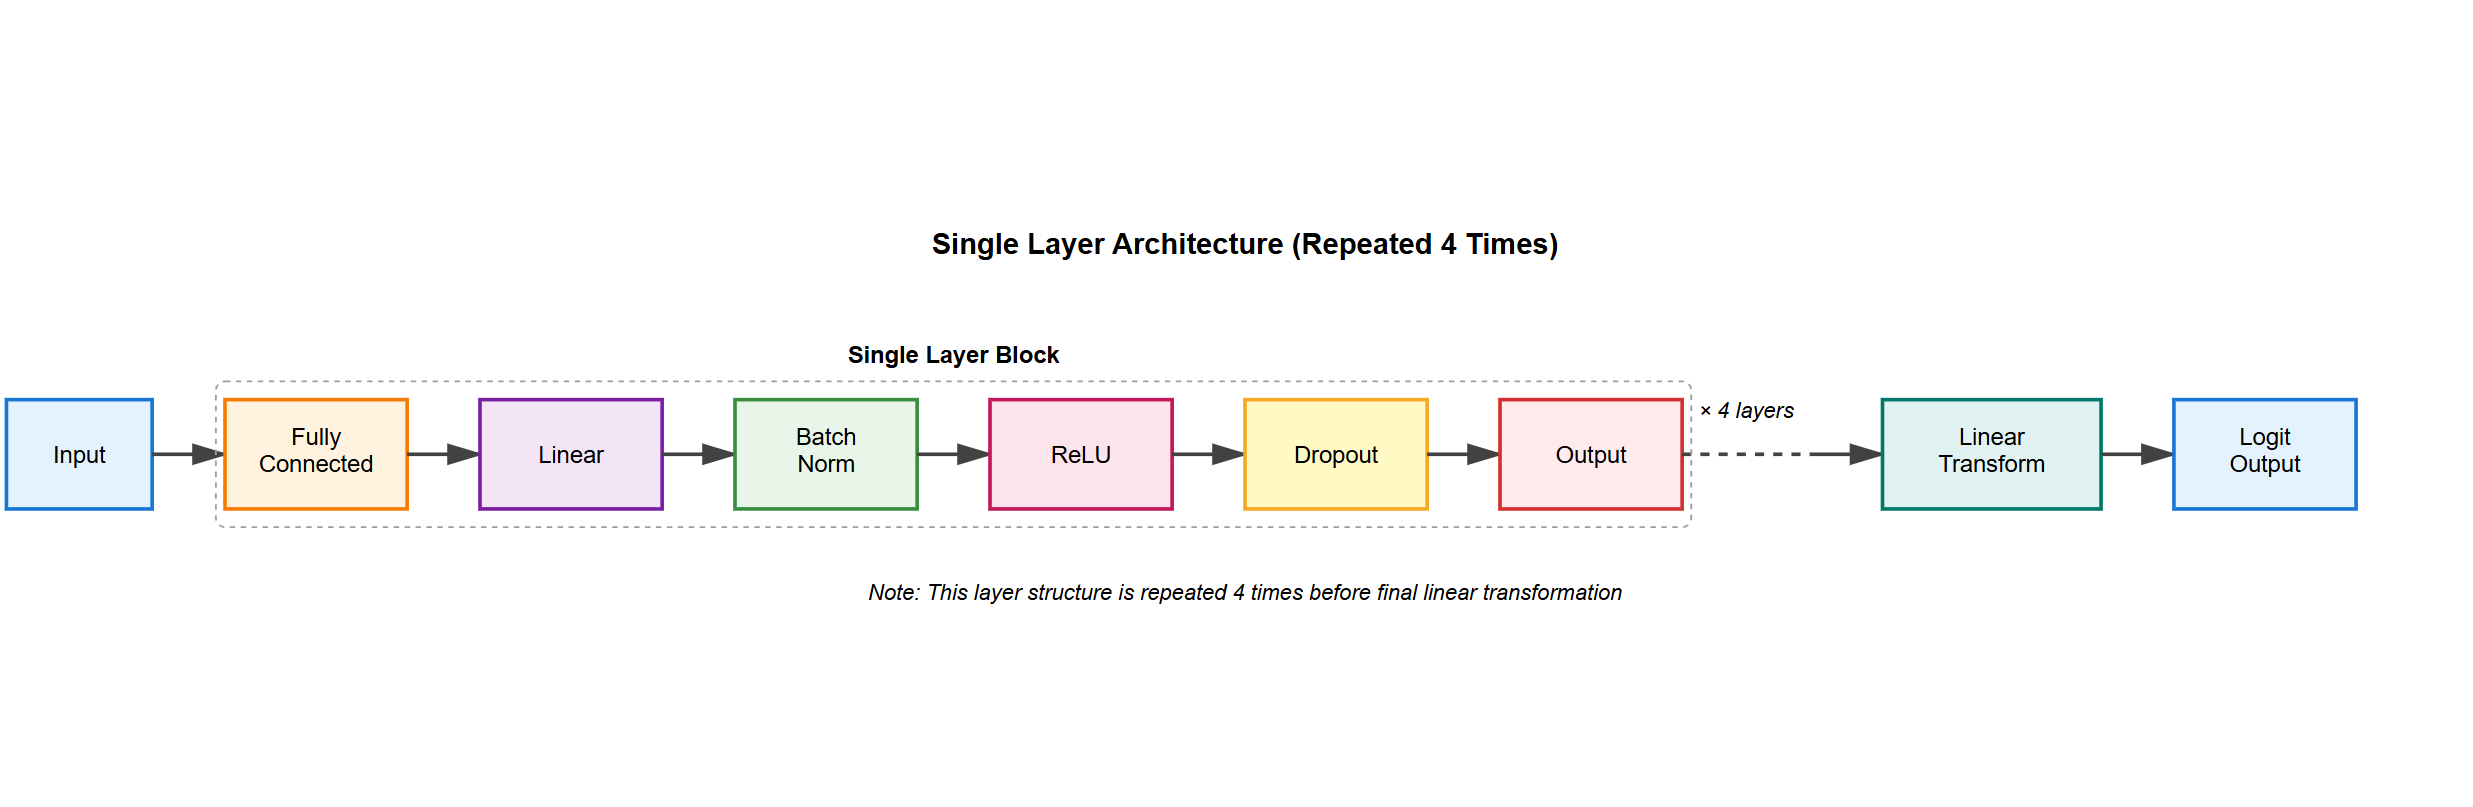

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

output_dim = N_TERMS_TO_PREDICT
MODEL_OUTPUT_DIM = 32

class MultiLabelNN(nn.Module):
    def __init__(self, input_dim=PCA_TARGET_DIM, output_dim=output_dim, hidden_dims=[256, 512, 1024, 2048], pos_weights=None, return_embeddings=False):
        super().__init__()
        self.pos_weights = pos_weights
        layers = []
        prev_dim = input_dim
        self.return_embeddings = return_embeddings

        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(prev_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.ReLU())
            # layers.append(nn.Dropout(0.1))
            prev_dim = hidden_dim

        self.features_sequential = nn.Sequential(*layers)
        self.logits_linear = nn.Linear(prev_dim, output_dim)

    def forward(self, x):
        features = self.features_sequential(x)
        if self.return_embeddings:
            return features
        logits = self.logits_linear(features)
        return logits

# weights can be added to help
class WeightedSoftF1Loss(nn.Module):
    def __init__(self, class_weights=None, epsilon=1e-7):
        super().__init__()
        self.weights = class_weights
        self.epsilon = epsilon

    def forward(self, logits, targets):
        probabilities = torch.sigmoid(logits)
        tp = (probabilities * targets).sum(dim=0)
        fp = (probabilities * (1 - targets)).sum(dim=0)
        fn = ((1 - probabilities) * targets).sum(dim=0)

        precision = tp / (tp + fp + self.epsilon)
        recall = tp / (tp + fn + self.epsilon)

        f1 = 2 * precision * recall / (precision + recall + self.epsilon)
        f1 = torch.clamp(f1, 0, 1)

        if self.weights is not None:
            weights = self.weights.to(logits.device)
            avg_f1 = (f1 * weights).sum() / weights.sum()
        else:
            avg_f1 = f1.mean()

        return 1 - avg_f1



## Helper method used to make f1 predictions for validation metrics

In [28]:
from sklearn.metrics import f1_score

def evaluate_f1(model, val_loader, device, threshold=0.5):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for features, targets in val_loader:
            features = features.to(device)
            targets = targets.to(device)

            logits = model(features)
            probs = torch.sigmoid(logits)

            preds = (probs > threshold).float()

            all_preds.append(preds.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    num_labels = all_targets.shape[1]
    f1_scores = []

    for i in range(num_labels):
        try:
            f1 = f1_score(all_targets[:, i], all_preds[:, i], zero_division=0   )
        except ValueError:
            f1 = 0.0
        f1_scores.append(f1)

    f1_scores = np.array(f1_scores)
    best_idx = np.argsort(f1_scores)[-3:]
    worst_idx = np.argsort(f1_scores)[:3]

    return f1_scores, best_idx, worst_idx


## Dataset class for protein embeddings dataset

In [29]:
class ProteinEmbeddingsDataset(Dataset):
    def __init__(self, features, labels, total_labels=output_dim, label_metadata=None, is_test=False):
        self.features = features.astype(np.float32)
        self.is_test = is_test
        if not is_test:
          self.labels = labels[:, :total_labels].astype(np.float32)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = torch.FloatTensor(self.features[idx])
        if not self.is_test:
          y = torch.FloatTensor(self.labels[idx])
          return x, y
        return x

In [30]:
def obtain_label_metadata(curr_y, output_dim):
    '''
    Calculates the weights for the loss function (a lot of terms are incredibly
    sparse as observed in the EDA)
    '''
    label_metadata = {
    "pos_weights": []
    }
    print(len(curr_y[0]))
    for i in range(output_dim):
        if not i % 1000: print(i)
        y_i = curr_y[:, i]
        pos = np.sum(y_i == 1)
        neg = np.sum(y_i == 0)
        scale_pos_weight = neg / pos if pos > 0 else 1.0
        label_metadata["pos_weights"].append(scale_pos_weight)
    return label_metadata


# Helper method which creates 3 different graphs per subontology
## A virtual node is added per subontoloy graph helps message passing due to sparsity, something that we did not observe in any paper, this improved performance since there is sparsity in the graph. Messages are able to be easily passed and the node embeddings can learn similarities and dissimilarities with respect to all the terms.

In [59]:
def obo_to_pyg(obo_path):
    G = obonet.read_obo(obo_path)
    nodes_F = [n for n in G.nodes if G.nodes[n]["namespace"] == "molecular_function"]
    nodes_C = [n for n in G.nodes if G.nodes[n]["namespace"] == "cellular_component"]
    nodes_P = [n for n in G.nodes if G.nodes[n]["namespace"] == "biological_process"]

    G_dict = {
        "F": G.subgraph(nodes_F),
        "C": G.subgraph(nodes_C),
        "P": G.subgraph(nodes_P)
    }
    G_data_dict = {}
    for k, curr_G in G_dict.items():
        go_list = sorted(curr_G.nodes())
        go_list.append("VIRTUAL")
        print(len(go_list))
        idx = {g:i for i,g in enumerate(go_list)}
        x = torch.arange(len(go_list), dtype=torch.long)
        e = []
        for edge in curr_G.edges:
            if edge[0] in idx and edge[1] in idx:
                e.append([idx[edge[0]], idx[edge[1]]])

        virtual_idx = idx["VIRTUAL"]
        for node_idx in range(len(go_list) - 1):
            e.append([virtual_idx, node_idx])
            e.append([node_idx, virtual_idx])

        edge_index = torch.tensor(e, dtype=torch.long).t().contiguous()
        G_data_dict[k] = Data(x=x, edge_index=edge_index, go_ids=go_list)
    return G_data_dict

In [32]:
import warnings
warnings.filterwarnings("ignore")
LR = 1e-5
EPOCHS = 50

def train_model(model, train_loader, val_loader, pos_weights, num_epochs=EPOCHS):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    pos_weights = pos_weights.to(device)

    optimizer = optim.Adam(model.parameters(), lr=LR)
    f1_soft_weighted = WeightedSoftF1Loss(pos_weights)
    train_loss_list = []
    val_loss_list = []
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0.0

        for features, targets in train_loader:
            features = features.to(device)
            targets = targets.to(device)
            logits = model(features)
            loss = f1_soft_weighted(logits, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        total_val_loss = 0.0

        with torch.no_grad():
            for val_features, val_targets in val_loader:
                val_features = val_features.to(device)
                val_targets = val_targets.to(device)
                val_logits = model(val_features)
                val_loss = f1_soft_weighted(val_logits, val_targets)
                total_val_loss += val_loss.item()

        avg_loss = total_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(val_loader)

        train_loss_list.append(avg_loss)
        val_loss_list.append(avg_val_loss)

        # Validate using the validation dataloader
        f1_scores, best_idx, worst_idx = evaluate_f1(model, val_loader, device)
        print(f"curr epoch {epoch+1}/{num_epochs}] loss: {avg_loss} val_loss {avg_val_loss}")
        print("Validation op 3 labels (best F1):")
        for idx in reversed(best_idx):
            print(f"Label {idx}: F1 = {f1_scores[idx]}")

        print("Validation Bottom 3 labels (worst F1):")
        for idx in worst_idx:
            print(f"Label {idx}: F1 = {f1_scores[idx]}")

        print(f"Validation average f1 score: {np.mean(f1_scores)}")

    plt.plot(
        range(1, num_epochs + 1),
        train_loss_list,
        label="Training Loss",
    )
    plt.plot(
        range(1, num_epochs + 1),
        val_loss_list,
        label="Validation Loss",
    )

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.savefig(f'two_tower_loss_DNN.png')
    plt.show()

    return model

In [33]:
protein_embeddings_dataset_train = ProteinEmbeddingsDataset(X_train_imputed, y_train_transformed, total_labels=output_dim)
protein_embeddings_dataset_val = ProteinEmbeddingsDataset(X_val_imputed, y_val_transformed, total_labels=output_dim)

600
0
curr epoch 1/50] loss: 0.9930949242649817 val_loss 0.9927731195757875
Validation op 3 labels (best F1):
Label 3: F1 = 0.6362957430918595
Label 193: F1 = 0.4411764705882353
Label 12: F1 = 0.32296705828150196
Validation Bottom 3 labels (worst F1):
Label 46: F1 = 0.0
Label 45: F1 = 0.0
Label 97: F1 = 0.0
Validation average f1 score: 0.02875863272221231
curr epoch 2/50] loss: 0.9926426721457962 val_loss 0.9922706375665806
Validation op 3 labels (best F1):
Label 3: F1 = 0.6362957430918595
Label 193: F1 = 0.5714285714285714
Label 12: F1 = 0.3224621038125861
Validation Bottom 3 labels (worst F1):
Label 46: F1 = 0.0
Label 45: F1 = 0.0
Label 97: F1 = 0.0
Validation average f1 score: 0.037549558859823244
curr epoch 3/50] loss: 0.9919952954862489 val_loss 0.9914701986222854
Validation op 3 labels (best F1):
Label 3: F1 = 0.6362957430918595
Label 193: F1 = 0.5740740740740741
Label 196: F1 = 0.5274725274725275
Validation Bottom 3 labels (worst F1):
Label 45: F1 = 0.0
Label 78: F1 = 0.0
Label 

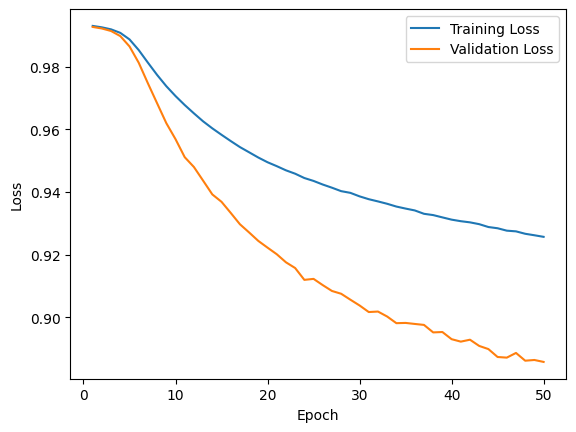

In [ ]:
HIDDEN_DIMS = [256, 512, 1024]
label_metadata = obtain_label_metadata(y_train_transformed, output_dim)
curr_model = MultiLabelNN(hidden_dims=HIDDEN_DIMS)
data_loader = DataLoader(protein_embeddings_dataset_train, batch_size=128)
data_loader_val = DataLoader(protein_embeddings_dataset_val, batch_size=len(X_val_imputed))
trained_model_nn = train_model(curr_model, data_loader, data_loader_val, torch.tensor(label_metadata["pos_weights"][:output_dim]))



## Predicting on validation set, saving ground truth as well as scores in the CAFA6 predictions format

In [ ]:
def predict(model, dataloader, device):
    model.eval()
    preds = []
    labels = []

    with torch.no_grad():
        for batch in dataloader:
            X, y = batch
            X = X.to(device)
            y = y.to(device)

            logits = model(X)
            out = torch.sigmoid(logits)
            preds.append(out.cpu())
            labels.append(y.cpu())

    preds = torch.cat(preds)
    labels = torch.cat(labels)
    return preds, labels


y_preds, y_labels = predict(trained_model_nn, data_loader_val, 'cuda')

pred_entry_ids_df = pd.DataFrame({"EntryID": X_val_entry_ids, "prediction": [row.tolist() for row in y_preds]})
label_names = mlb.classes_[:output_dim]
num_labels = len(label_names)
pred_matrix = np.vstack(pred_entry_ids_df["prediction"].values)

pred_df = pd.DataFrame(pred_matrix, columns=label_names)

prediction_df = pd.concat([pred_entry_ids_df[["EntryID"]], pred_df], axis=1)
go_cols = [c for c in prediction_df.columns if c != "EntryID"]
to_score_df = prediction_df.melt(id_vars="EntryID", value_vars=go_cols, var_name="term", value_name="score")

to_score_df = to_score_df.sort_values(["EntryID", "term"]).reset_index(drop=True)
to_score_df["score"] = to_score_df["score"].round(3)
to_score_df = to_score_df[to_score_df["score"] != 0]
to_score_df.to_csv(f"to_score_DNN.tsv", header=False, index=False, sep="\t")


ground_truth_score_df = protein_function_df[protein_function_df["EntryID"].isin(X_val_entry_ids)][["EntryID", "term"]]
ground_truth_score_df.to_csv(f"ground_truth_score_DNN.tsv", header=False, index=False, sep="\t")



In [ ]:
torch.save(trained_model_nn.state_dict(), "DNN_subset.pth")

# Let's start exploring GNN approaches

In [60]:
G_data_dict = obo_to_pyg(obo_path)

10132
4042
25951


In [ ]:
G_data_dict

{'F': Data(x=[10132], edge_index=[2, 32831], go_ids=[10132]),
 'C': Data(x=[4042], edge_index=[2, 14520], go_ids=[4042]),
 'P': Data(x=[25951], edge_index=[2, 110122], go_ids=[25951])}

In [34]:

import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax
from torch_geometric.utils import add_self_loops

class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, n_terms, emb=False):
        super(GNNStack, self).__init__()
        conv_model = self.build_conv_model(args["model_type"])
        self.embeddings = nn.Embedding(n_terms, input_dim)
        self.convs = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        assert (args["num_layers"] >= 1), 'Number of layers is not >=1'
        for l in range(args["num_layers"]-1):
            self.convs.append(conv_model(args["heads"] * hidden_dim, hidden_dim))

        self.post_mp = nn.Sequential(
            nn.Linear(args["heads"] * hidden_dim, hidden_dim), nn.Dropout(args["dropout"]),
            nn.Linear(hidden_dim, output_dim))

        self.dropout = args["dropout"]
        self.num_layers = args["num_layers"]

        self.emb = emb

    def build_conv_model(self, model_type):
        if model_type == 'GraphSage':
            return GraphSage
        elif model_type == 'GAT':
            return GAT

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        x_emb = self.embeddings(x)
        for i in range(self.num_layers):
            x_emb = self.convs[i](x_emb, edge_index)
            x_emb = F.relu(x_emb)
            x_emb = F.dropout(x_emb, p=self.dropout,training=self.training)

        x_emb = self.post_mp(x_emb)

        return x_emb


class GraphSage(MessagePassing):

    def __init__(self, in_channels, out_channels, normalize = True,
                 bias = False, **kwargs):
        super(GraphSage, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize

        self.lin_l = None
        self.lin_r = None

        self.lin_l = nn.Linear(in_channels, out_channels, bias=bias)
        self.lin_r = nn.Linear(in_channels, out_channels, bias=bias)

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x, edge_index, size = None):
        out = None
        num_nodes = x.size()[0]
        edge_index, _ = add_self_loops(edge_index, num_nodes=num_nodes) # self loops are because some nodes are isolated (mitigated thanks to virtual node)
        out = self.propagate(x=x, edge_index=edge_index)

        out = self.lin_l(x) + self.lin_r(out)
        if self.normalize: out = torch.nn.functional.normalize(out)

        return out

    def message(self, x_j):
        out = None
        out = x_j

        return out

    def aggregate(self, inputs, index, dim_size = None):
        out = None
        # The axis along which to index number of nodes.
        node_dim = self.node_dim
        out = torch_scatter.scatter(inputs, index, dim=0, reduce='mean')
        return out

class GAT(MessagePassing):

    def __init__(self, in_channels, out_channels, heads = 2,
                 negative_slope = 0.2, dropout = 0.1, **kwargs):
        super(GAT, self).__init__(node_dim=0, **kwargs)
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.negative_slope = negative_slope
        self.dropout = dropout
        self.lin_l = None
        self.lin_r = None
        self.att_l = None
        self.att_r = None
        self.lin_l, self.lin_r = nn.Linear(in_channels, out_channels * self.heads), nn.Linear(in_channels, out_channels * self.heads)
        self.att_l, self.att_r = nn.Parameter(torch.empty(self.heads, out_channels)), nn.Parameter(torch.empty(self.heads, out_channels))
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin_l.weight)
        nn.init.xavier_uniform_(self.lin_r.weight)
        nn.init.xavier_uniform_(self.att_l)
        nn.init.xavier_uniform_(self.att_r)

    def forward(self, x, edge_index, size = None):
        H, C = self.heads, self.out_channels
        W_l_transformed_x, W_r_transformed_x = self.lin_l(x), self.lin_r(x)
        N = x.size(0)
        x_l = W_l_transformed_x.view(N, H, C)
        x_r = W_r_transformed_x.view(N, H, C)
        alpha_central = (x_l * self.att_l.unsqueeze(0)).sum(dim=-1)
        alpha_neighbors = (x_r * self.att_r.unsqueeze(0)).sum(dim=-1)
        num_nodes = x.size()[0]
        edge_index, _ = add_self_loops(edge_index, num_nodes=num_nodes) # self loops are because some nodes are isolated (mitigated thanks to virtual node)
        out = self.propagate(edge_index, x=(x_l, x_r), alpha=(alpha_central, alpha_neighbors), size=size)
        out = out.view(N, H * C)
        return out


    def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):
        alpha = alpha_i + alpha_j
        alpha = F.leaky_relu(alpha, negative_slope=.2)
        alpha = softmax(alpha,index,num_nodes=size_i, ptr=ptr)
        alpha = F.dropout(alpha, training=self.training, p=self.dropout)
        out = x_j * alpha.unsqueeze(-1)
        return out


    def aggregate(self, inputs, index, dim_size = None):
        out = torch_scatter.scatter(inputs, index, dim=0)

        return out


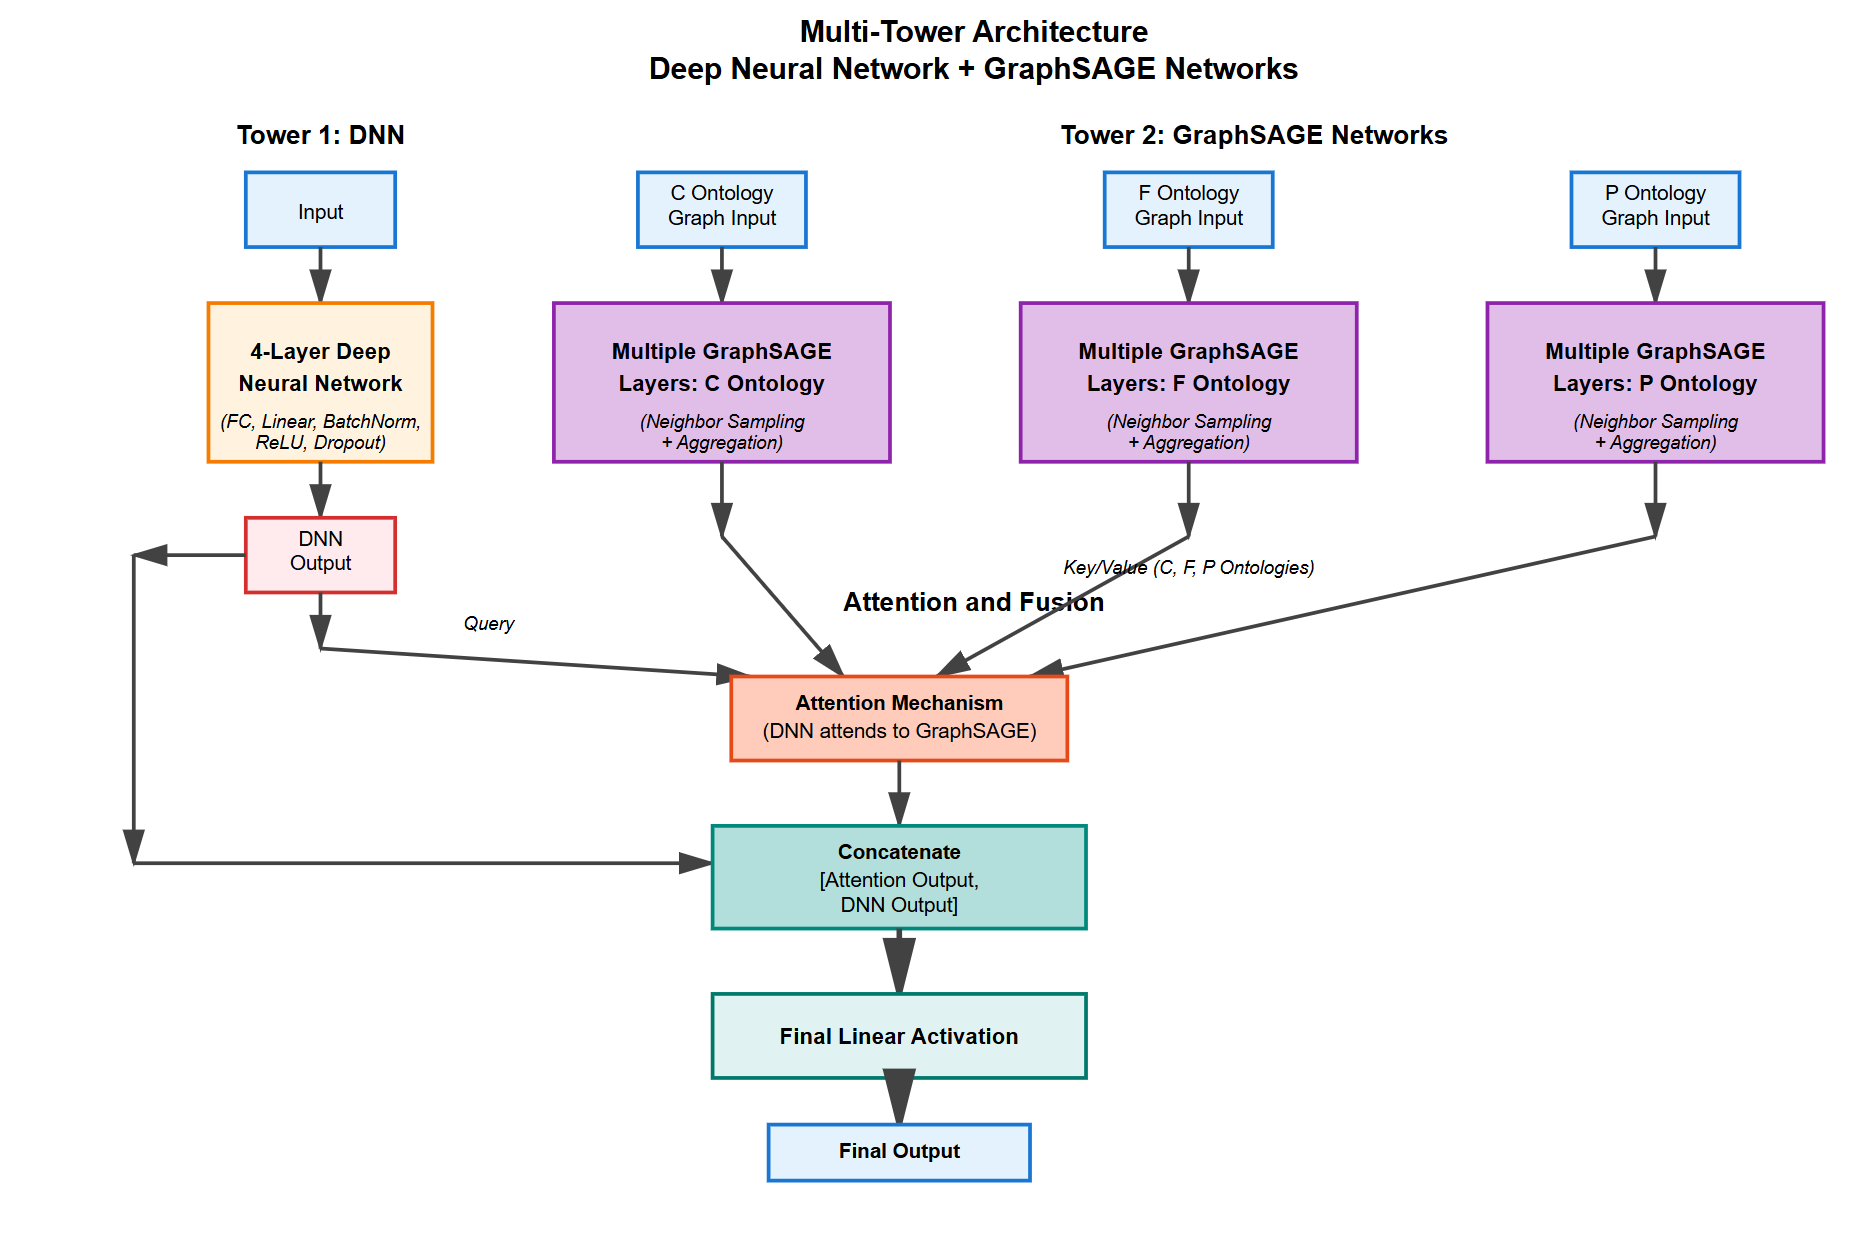

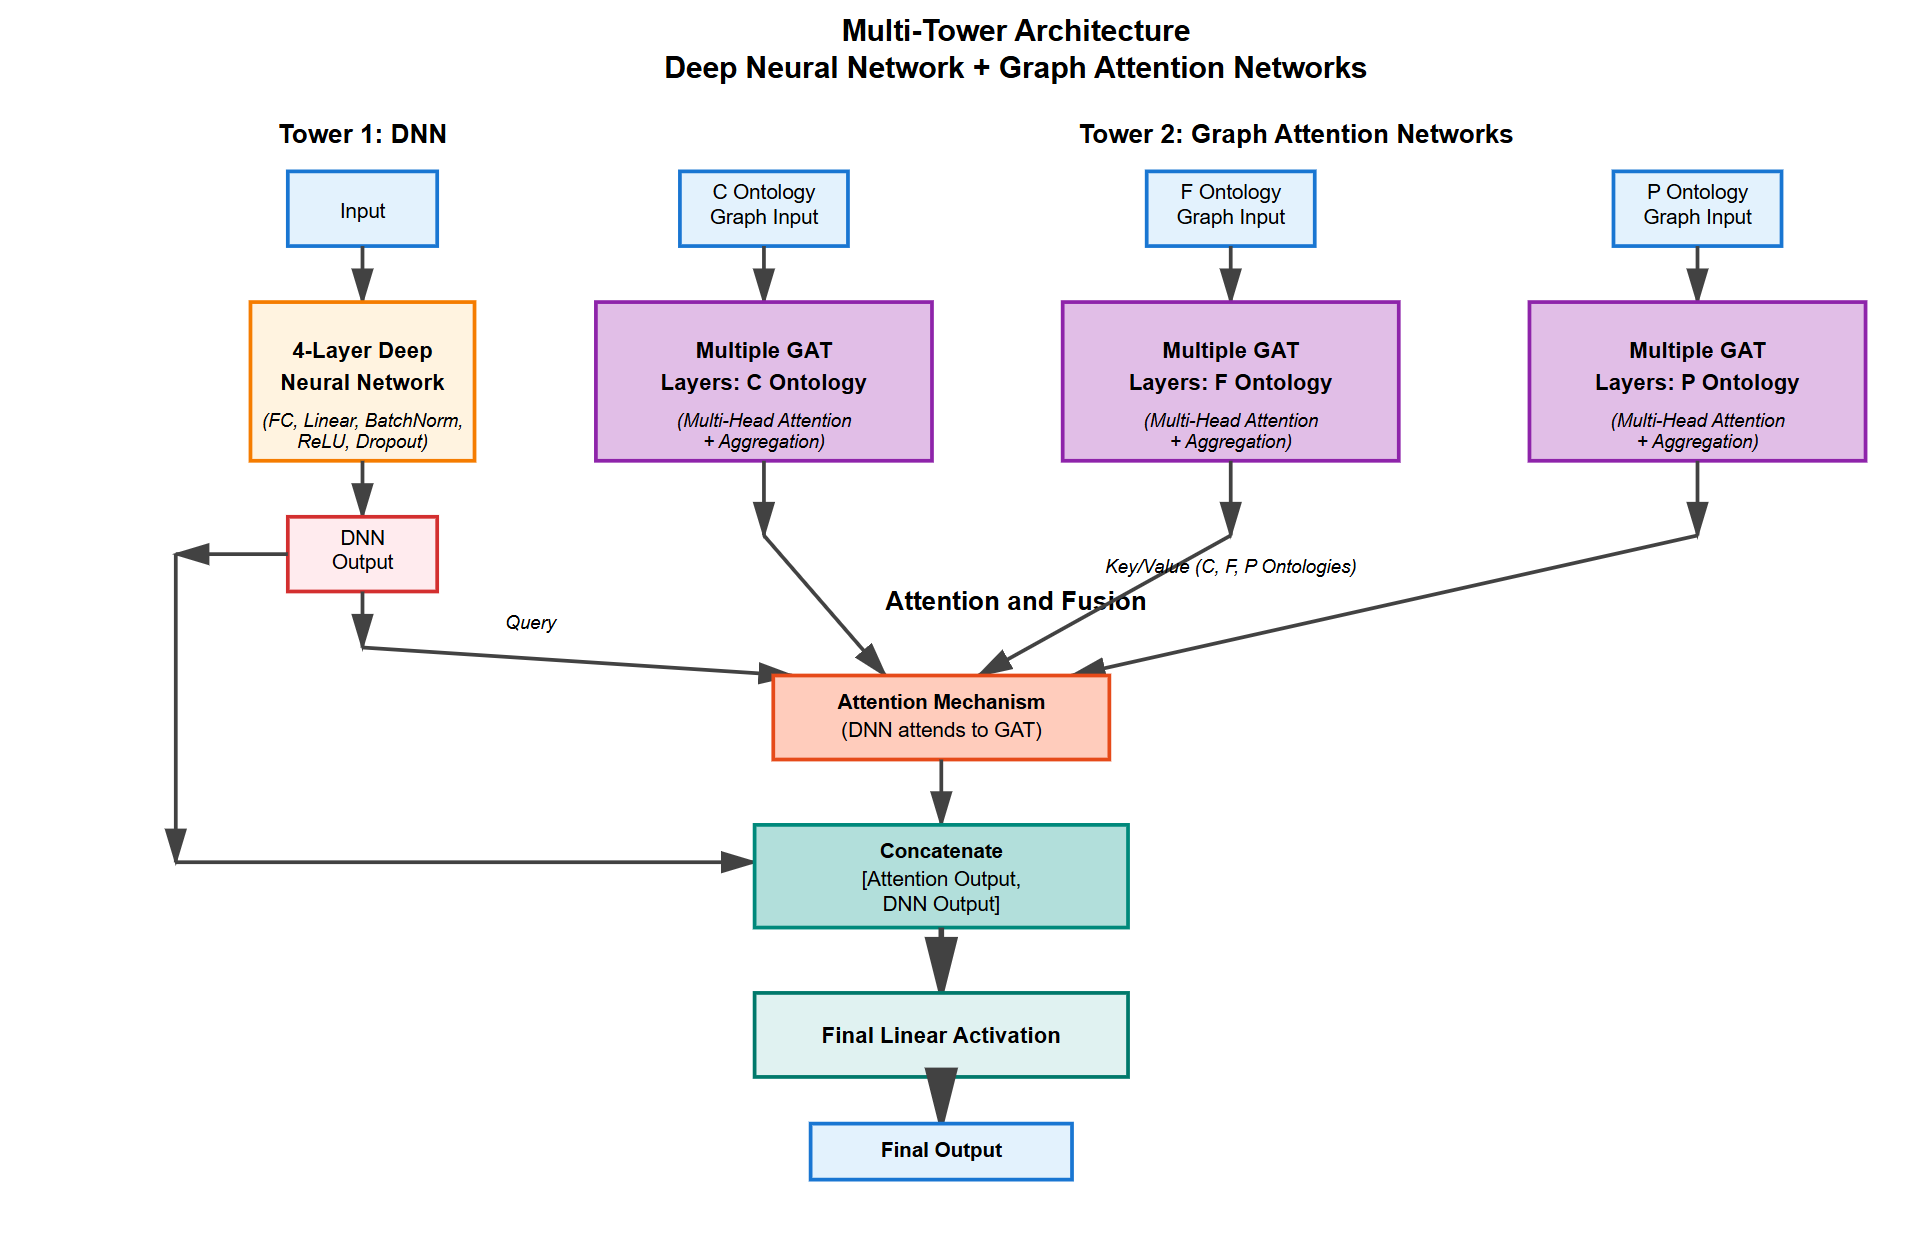

## For our GNN enhanced approaches we create a Multi-tower approach where we include the NN model defined previously with 3 GNN towers, one for each subontology. The idea is to learn relevant embeddings in our graphs of dimension N_NODES_SUBONTOLOGY * DIM, and obtain attention scores using processed protein embedding sequences (processed by the DNN) and graph node embeddings which correspond to GO terms interacting with other GO terms. Intuitively, we expect protein to have stronger interactions with GO nodes that have their terms.

Note that the graphs are static for each subontology, a transductive setting is expected.

In [35]:
import math
args_dict = {
    "heads": 1,
    "dropout": 0.1,
    "num_layers": 3, # More than 3 layers impacted performance negatively
    "model_type": "GraphSage"
}

# Initial iteration where we had only one GNN trained (3 models were trained in total per GNN which didn't have strong generalization power)

# class TwoTowerGNNAndNN(torch.nn.Module):
#     def __init__(self, input_dim, hidden_dim, logits_dim, output_dim, graph_edge_dim, args_dict):
#         super().__init__()
#         self.NN = MultiLabelNN(input_dim=input_dim, output_dim=logits_dim)
#         self.GNN = GNNStack(input_dim, hidden_dim, logits_dim, args_dict, graph_edge_dim)
#         self.graph_edge_dim = graph_edge_dim
#         self.W_map_graph = nn.Linear(graph_edge_dim, hidden_dim)
#         self.final = nn.Linear(logits_dim, output_dim)
#         self._init_weights

#     def _init_weights(self):
#         for module in self.NN.modules():
#             if isinstance(module, nn.Linear):
#                 nn.init.xavier_uniform_(module.weight)
#                 if module.bias is not None:
#                     nn.init.zeros_(module.bias)

#         for gnn in [self.GNN_C, self.GNN_F, self.GNN_P]:
#             for module in gnn.modules():
#                 if isinstance(module, nn.Linear):
#                     nn.init.xavier_uniform_(module.weight)
#                     if module.bias is not None:
#                         nn.init.zeros_(module.bias)

#         nn.init.xavier_uniform_(self.final.weight)
#         nn.init.zeros_(self.final.bias)


#     def forward(self, x_protein_embeddings, x_nodes, size=None):
#         x_p = self.NN(x_protein_embeddings)
#         x_n = self.GNN(x_nodes)
#         x_n = self.W_map_graph(x_n.T)
#         x_n = x_n.mean(dim=1)
#         x = x_p + x_n
#         logits = self.final(x)
#         return logits


class TwoTowerGNNAndNN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, logits_dim, output_dim, graph_edge_dim_C, graph_edge_dim_F, graph_edge_dim_P, args_dict, hidden_dims=[256, 512, 1024, 2048]):
        super().__init__()

        self.NN = MultiLabelNN(input_dim=input_dim, output_dim=logits_dim, hidden_dims=hidden_dims)
        self.GNN_C = GNNStack(input_dim, hidden_dim, logits_dim, args_dict, graph_edge_dim_C)
        self.GNN_F = GNNStack(input_dim, hidden_dim, logits_dim, args_dict, graph_edge_dim_F)
        self.GNN_P = GNNStack(input_dim, hidden_dim, logits_dim, args_dict, graph_edge_dim_P)
        self.final = nn.Linear(logits_dim*4, output_dim)

    def forward(self, x_protein_embeddings, x_nodes_C, x_nodes_F, x_nodes_P, size=None):
        x_p = self.NN(x_protein_embeddings) # current protein embedding
        x_n_C = self.GNN_C(x_nodes_C) # graph embedding subontology C
        x_n_F = self.GNN_F(x_nodes_F) # graph embedding subontology F
        x_n_P = self.GNN_P(x_nodes_P) # graph embedding subontology P
        # Compute attention scores between the protein and graph, terms that are present in the protein will have higher attention scores (QKT = X_PX_NT)
        QKT_C = torch.matmul(x_p, x_n_C.T)
        QKT_P = torch.matmul(x_p, x_n_P.T)
        QKT_F = torch.matmul(x_p, x_n_F.T)
        attention_weights_C = F.softmax(QKT_C / math.sqrt(x_p.size(-1)), dim=-1)
        attention_weights_F = F.softmax(QKT_F / math.sqrt(x_p.size(-1)), dim=-1)
        attention_weights_P = F.softmax(QKT_P / math.sqrt(x_p.size(-1)), dim=-1)

        x_n_weighted_C = torch.matmul(attention_weights_C, x_n_C)
        x_n_weighted_F = torch.matmul(attention_weights_F, x_n_F)
        x_n_weighted_P = torch.matmul(attention_weights_P, x_n_P)

        x_n_weighted = x_n_weighted_C + x_n_weighted_F + x_n_weighted_P
        x_add = x_p + x_n_weighted


        x_cat = torch.cat([x_p, x_n_weighted_C, x_n_weighted_F, x_n_weighted_P], dim=-1)
        logits = self.final(x_cat)
        return logits



In [37]:
def evaluate_f1_multi_tower(model, val_loader, device,  graph_data_C, graph_data_F, graph_data_P, threshold=0.5):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for features, targets in val_loader:
            features = features.to(device)
            targets = targets.to(device)

            logits = model(features,  graph_data_C, graph_data_F, graph_data_P)
            probs = torch.sigmoid(logits)

            preds = (probs > threshold).float()

            all_preds.append(preds.cpu().numpy())
            all_targets.append(targets.cpu().numpy())

    all_preds = np.concatenate(all_preds, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    num_labels = all_targets.shape[1]
    f1_scores = []

    for i in range(num_labels):
        try:
            f1 = f1_score(all_targets[:, i], all_preds[:, i], zero_division=0   )
        except ValueError:
            f1 = 0.0
        f1_scores.append(f1)

    f1_scores = np.array(f1_scores)
    best_idx = np.argsort(f1_scores)[-3:]
    worst_idx = np.argsort(f1_scores)[:3]

    return f1_scores, best_idx, worst_idx


In [36]:
import warnings
warnings.filterwarnings("ignore")

def train_model_two_tower(model, train_loader, val_loader, graph_data_C, graph_data_F, graph_data_P, pos_weights, num_epochs=50):
    train_loss_list = []
    val_loss_list = []
    train_f1_score = []
    val_f1_score = []

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    pos_weights = pos_weights.to(device)
    graph_data_C = graph_data_C.to(device)
    graph_data_F = graph_data_F.to(device)
    graph_data_P = graph_data_P.to(device)

    optimizer = optim.Adam(model.parameters(), lr=1e-4)
    f1_soft_weighted = WeightedSoftF1Loss(pos_weights)
    for epoch in range(num_epochs):

        model.train()
        total_loss = 0.0

        for features, targets in train_loader:
            features = features.to(device)
            targets = targets.to(device)
            logits = model(features, graph_data_C, graph_data_F, graph_data_P)


            loss = f1_soft_weighted(logits, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        total_val_loss = 0.0
        avg_val_loss = 0.0
        if val_loader is not None:
          with torch.no_grad():
              for val_features, val_targets in val_loader:
                  val_features = val_features.to(device)
                  val_targets = val_targets.to(device)
                  val_logits = model(val_features, graph_data_C, graph_data_F, graph_data_P)
                  val_loss = f1_soft_weighted(val_logits, val_targets)
                  total_val_loss += val_loss.item()
          avg_val_loss = total_val_loss / len(val_loader)

        avg_loss = total_loss / len(train_loader)


        train_loss_list.append(avg_loss)


        # Validate using the validation dataloader

        print(f"curr epoch {epoch+1}/{num_epochs}] loss: {avg_loss} val_loss {avg_val_loss}")
        if val_loader is not None:
          val_loss_list.append(avg_val_loss)
          f1_scores, best_idx, worst_idx = evaluate_f1_multi_tower(model, val_loader, device,  graph_data_C, graph_data_F, graph_data_P)
          print("Validation op 3 labels (best F1):")
          for idx in reversed(best_idx):
              print(f"Label {idx}: F1 = {f1_scores[idx]}")

          print("Validation Bottom 3 labels (worst F1):")
          for idx in worst_idx:
              print(f"Label {idx}: F1 = {f1_scores[idx]}")

          print(f"Validation average f1 score: {np.mean(f1_scores)}")

    plt.plot(
        range(1, num_epochs + 1),
        train_loss_list,
        label="Training Loss",
    )
    if val_loader is not None:
      plt.plot(
          range(1, num_epochs + 1),
          val_loss_list,
          label="Validation Loss",
      )

    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.savefig(f'two_tower_loss_{args_dict["model_type"]}.png')
    plt.show()
    return model

600
0
curr epoch 1/50] loss: 0.9836712665603036 val_loss 0.9417094270700759
Validation op 3 labels (best F1):
Label 52: F1 = 1.0
Label 3: F1 = 0.6362957430918595
Label 193: F1 = 0.55
Validation Bottom 3 labels (worst F1):
Label 15: F1 = 0.0
Label 20: F1 = 0.0
Label 44: F1 = 0.0
Validation average f1 score: 0.10033336295034566
curr epoch 2/50] loss: 0.9570202524540194 val_loss 0.9232420120702041
Validation op 3 labels (best F1):
Label 3: F1 = 0.6362957430918595
Label 52: F1 = 0.6153846153846154
Label 196: F1 = 0.5473684210526316
Validation Bottom 3 labels (worst F1):
Label 15: F1 = 0.0
Label 31: F1 = 0.0
Label 48: F1 = 0.0
Validation average f1 score: 0.1156080480140221
curr epoch 3/50] loss: 0.9472916617340161 val_loss 0.9074071833121884
Validation op 3 labels (best F1):
Label 52: F1 = 0.8888888888888888
Label 3: F1 = 0.6362957430918595
Label 196: F1 = 0.5531914893617021
Validation Bottom 3 labels (worst F1):
Label 15: F1 = 0.0
Label 38: F1 = 0.0
Label 48: F1 = 0.0
Validation average f

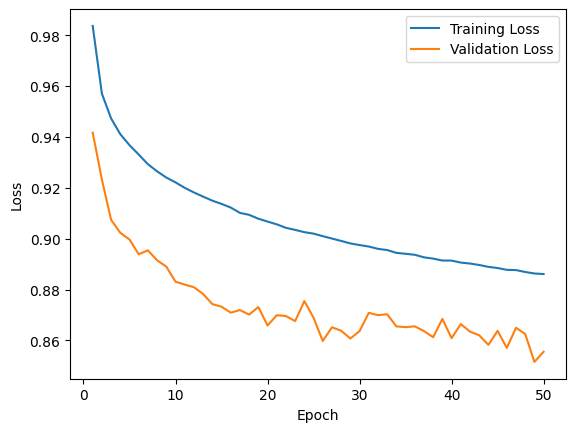

In [ ]:
# G_data_dict = obo_to_pyg(obo_path) # Get dictionaries

label_metadata = obtain_label_metadata(y_train_transformed, output_dim)
data_loader = DataLoader(protein_embeddings_dataset_train, batch_size=128)
data_loader_val = DataLoader(protein_embeddings_dataset_val, batch_size=len(X_val_imputed))
curr_model = TwoTowerGNNAndNN(PCA_TARGET_DIM, 32, 64, output_dim,  G_data_dict['C'].x.size()[0], G_data_dict['F'].x.size()[0], G_data_dict['P'].x.size()[0], args_dict)
trained_model_two_tower_gsage = train_model_two_tower(curr_model, data_loader, data_loader_val, G_data_dict['C'], G_data_dict['F'], G_data_dict['P'], torch.tensor(label_metadata["pos_weights"][:output_dim]))

# Performance is higher thanks to the graph GNN applied to all subontologies + attention scores

In [ ]:
def predict_two_tower(model, dataloader, G_data_C, G_data_F, G_data_P, device):
    model.eval()
    preds = []
    labels = []

    with torch.no_grad():
        for batch in dataloader:
            X, y = batch
            X = X.to(device)
            y = y.to(device)

            logits = model(X, G_data_C, G_data_F, G_data_P)
            out = torch.sigmoid(logits)
            preds.append(out.cpu())
            labels.append(y.cpu())

    preds = torch.cat(preds)
    labels = torch.cat(labels)
    return preds, labels


y_preds, y_labels = predict_two_tower(trained_model_two_tower_gsage, data_loader_val,  G_data_dict['C'], G_data_dict['F'], G_data_dict['P'], 'cuda')

pred_entry_ids_df = pd.DataFrame({"EntryID": X_val_entry_ids, "prediction": [row.tolist() for row in y_preds]})
label_names = mlb.classes_[:output_dim]
num_labels = len(label_names)
pred_matrix = np.vstack(pred_entry_ids_df["prediction"].values)

pred_df = pd.DataFrame(pred_matrix, columns=label_names)

prediction_df = pd.concat([pred_entry_ids_df[["EntryID"]], pred_df], axis=1)
go_cols = [c for c in prediction_df.columns if c != "EntryID"]
to_score_df = prediction_df.melt(id_vars="EntryID", value_vars=go_cols, var_name="term", value_name="score")

to_score_df = to_score_df.sort_values(["EntryID", "term"]).reset_index(drop=True)
to_score_df["score"] = to_score_df["score"].round(3)
to_score_df = to_score_df[to_score_df["score"] != 0]
to_score_df.to_csv(f"to_score_GSage.tsv", header=False, index=False, sep="\t")


ground_truth_score_df = protein_function_df[protein_function_df["EntryID"].isin(X_val_entry_ids)][["EntryID", "term"]]
ground_truth_score_df.to_csv(f"ground_truth_score_GSage.tsv", header=False, index=False, sep="\t")



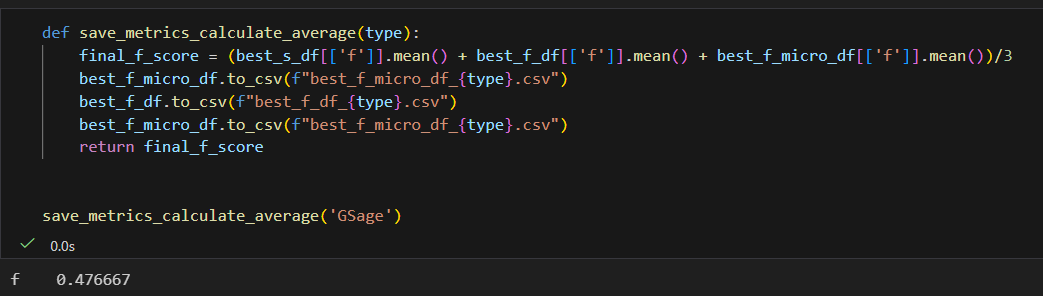

## Applied in the CAFA EVAL repo and averaging the f scores accross subontologies (current maximum score in the competition is 3.91, while we focus on a much smaller subset, we did not use the best embeddings or common approaches like training individual logistic regression models for all sparse terms or using external datasets to enhance the data as well as using ProtT5 embedding models combined with ESM)

## Now we can perform Graph attention

600
0
curr epoch 1/50] loss: 0.9828221146980595 val_loss 0.9467487724565524
Validation op 3 labels (best F1):
Label 52: F1 = 0.6666666666666666
Label 3: F1 = 0.6362957430918595
Label 183: F1 = 0.4444444444444444
Validation Bottom 3 labels (worst F1):
Label 5: F1 = 0.0
Label 15: F1 = 0.0
Label 13: F1 = 0.0
Validation average f1 score: 0.07333383731101498
curr epoch 2/50] loss: 0.9649425812671808 val_loss 0.9368931606164188
Validation op 3 labels (best F1):
Label 52: F1 = 1.0
Label 3: F1 = 0.6362957430918595
Label 196: F1 = 0.5777777777777777
Validation Bottom 3 labels (worst F1):
Label 13: F1 = 0.0
Label 15: F1 = 0.0
Label 31: F1 = 0.0
Validation average f1 score: 0.09579026425415325
curr epoch 3/50] loss: 0.9571747596708423 val_loss 0.9277424151434668
Validation op 3 labels (best F1):
Label 52: F1 = 1.0
Label 3: F1 = 0.6362957430918595
Label 183: F1 = 0.6153846153846154
Validation Bottom 3 labels (worst F1):
Label 13: F1 = 0.0
Label 15: F1 = 0.0
Label 31: F1 = 0.0
Validation average f1

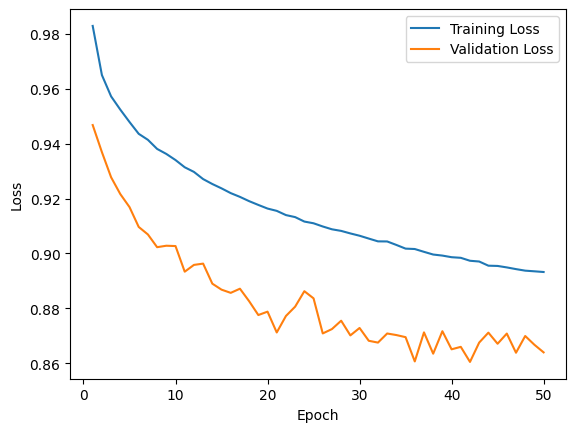

In [ ]:
args_dict = {
    "heads": 2,
    "dropout": 0.1,
    "num_layers": 3,
    "model_type": "GAT"
}


label_metadata = obtain_label_metadata(y_train_transformed, output_dim)
data_loader = DataLoader(protein_embeddings_dataset_train, batch_size=128)
data_loader_val = DataLoader(protein_embeddings_dataset_val, batch_size=len(X_val_imputed))

curr_model = TwoTowerGNNAndNN(PCA_TARGET_DIM, 32, 64, output_dim, G_data_dict['C'].x.size()[0], G_data_dict['F'].x.size()[0], G_data_dict['P'].x.size()[0], args_dict)
trained_model_nn_gat = train_model_two_tower(curr_model, data_loader, data_loader_val, G_data_dict['C'], G_data_dict['F'], G_data_dict['P'], torch.tensor(label_metadata["pos_weights"][:output_dim]))

In [ ]:

y_preds, y_labels = predict_two_tower(trained_model_nn_gat, data_loader_val,  G_data_dict['C'], G_data_dict['F'], G_data_dict['P'], 'cuda')

pred_entry_ids_df = pd.DataFrame({"EntryID": X_val_entry_ids, "prediction": [row.tolist() for row in y_preds]})
label_names = mlb.classes_[:output_dim]
num_labels = len(label_names)
pred_matrix = np.vstack(pred_entry_ids_df["prediction"].values)

pred_df = pd.DataFrame(pred_matrix, columns=label_names)

prediction_df = pd.concat([pred_entry_ids_df[["EntryID"]], pred_df], axis=1)
go_cols = [c for c in prediction_df.columns if c != "EntryID"]
to_score_df = prediction_df.melt(id_vars="EntryID", value_vars=go_cols, var_name="term", value_name="score")

to_score_df = to_score_df.sort_values(["EntryID", "term"]).reset_index(drop=True)
to_score_df["score"] = to_score_df["score"].round(3)
to_score_df = to_score_df[to_score_df["score"] != 0]
to_score_df.to_csv(f"to_score_GAT.tsv", header=False, index=False, sep="\t")


ground_truth_score_df = protein_function_df[protein_function_df["EntryID"].isin(X_val_entry_ids)][["EntryID", "term"]]
ground_truth_score_df.to_csv(f"ground_truth_score_GAT.tsv", header=False, index=False, sep="\t")



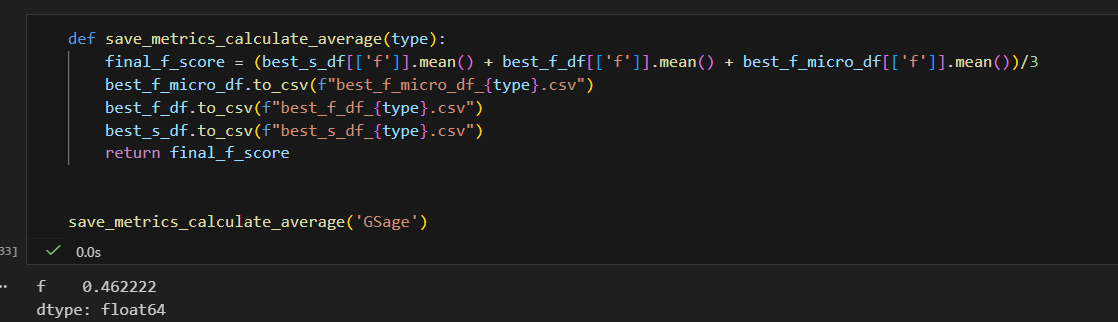

# Final model setups 🎉
## We now train models using the full training data (all the terms which end up being 26,125 in total)
## All model training setups are defined DNN, GSAGE + DNN, and GAT + DNN


In [42]:
protein_function_unique_metadata = protein_function_df["term"].unique()
N_TERMS_TO_PREDICT = len(protein_function_unique_metadata)
output_dim = N_TERMS_TO_PREDICT
grouped_df, protein_function_unique_metadata = group_terms_and_aspects(protein_function_df, N_TERMS_TO_PREDICT, get_all=True)

len(protein_function_unique_metadata)

get_all: True


26125

# We essentially follow the exact same steps as done for the initial experiments, however, we include the fasta test embedding that were processed earlier using a batch approach


In [73]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
N_TERMS_TO_PREDICT = len(protein_function_unique_metadata)
output_dim = N_TERMS_TO_PREDICT
INCLUDE_TEST = True
test_df = fasta_emb_df_test
# Columns for Training and Columns for Testing
PREDICTORS = [f"emb_{i}" for i in range(PCA_TARGET_DIM)]
PREDICTORS.append("EntryID")

OUTPUTS = ['output_terms']
subontology_train_val_test_dic = {}
if INCLUDE_TEST:
  X_test = test_df[PREDICTORS].values
X, y = grouped_df[PREDICTORS].values, grouped_df[OUTPUTS].iloc[:, 0].tolist()
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.001, random_state=42)


X_train_entry_ids = [data_row[-1] for data_row in X_train]
X_val_entry_ids = [data_row[-1] for data_row in X_val]
X_train = np.array([data_row[:-1] for data_row in X_train])
X_val = np.array([data_row[:-1] for data_row in X_val])
if INCLUDE_TEST:
    print(len(X_val[0]))
    print(len(X_test[0]))
    X_test = np.array([data_row[:-1] for data_row in X_test])
    X_test_entry_ids = [data_row[-1] for data_row in X_test]

term_to_index = {term: i for i, term in enumerate(protein_function_unique_metadata)}

mlb = MultiLabelBinarizer(classes=protein_function_unique_metadata)
y_train_transformed = mlb.fit_transform(y_train)
y_val_transformed = mlb.transform(y_val)
print(y_val_transformed[0])
from sklearn.impute import SimpleImputer
imputer = SimpleImputer(strategy="constant", fill_value=0)
X_train_imputed = imputer.fit_transform(X_train)
X_val_imputed = imputer.transform(X_val)
X_test_imputed = imputer.transform(X_test)

scaler = StandardScaler()
X_train_imputed = scaler.fit_transform(X_train_imputed)
X_val_imputed = scaler.transform(X_val_imputed)
X_test_imputed = scaler.transform(X_test_imputed)

128
129
[0 0 0 ... 0 0 0]


In [78]:
X_test_entry_ids = fasta_emb_df_test['EntryID'].values

In [44]:
len(X_test_imputed)

82154

In [45]:
len(y_train_transformed[0]), output_dim


(26125, 26125)

In [46]:
protein_embeddings_dataset_train = ProteinEmbeddingsDataset(X_train_imputed, y_train_transformed, total_labels=output_dim)
protein_embeddings_dataset_val = ProteinEmbeddingsDataset(X_val_imputed, y_val_transformed, total_labels=output_dim)
protein_embeddings_dataset_test = ProteinEmbeddingsDataset(X_test, None, total_labels=output_dim, is_test=True)


In [47]:
output_dim = len(protein_function_unique_metadata)
label_metadata = obtain_label_metadata(y_train_transformed, output_dim) # Allows us to store weights per term

26125
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000


In [48]:
len(label_metadata["pos_weights"])

26125

curr epoch 1/5] loss: 0.9999346601225598 val_loss 0.999921209979181
Validation op 3 labels (best F1):
Label 6: F1 = 0.36666666666666664
Label 3022: F1 = 0.3333333333333333
Label 53: F1 = 0.2736842105263158
Validation Bottom 3 labels (worst F1):
Label 17403: F1 = 0.0
Label 17415: F1 = 0.0
Label 17414: F1 = 0.0
Validation average f1 score: 0.0004067381640415806
curr epoch 2/5] loss: 0.9999334893102505 val_loss 0.9999187188965472
Validation op 3 labels (best F1):
Label 6: F1 = 0.36923076923076925
Label 3022: F1 = 0.3333333333333333
Label 17266: F1 = 0.2857142857142857
Validation Bottom 3 labels (worst F1):
Label 17404: F1 = 0.0
Label 17416: F1 = 0.0
Label 17415: F1 = 0.0
Validation average f1 score: 0.00043191825291658356
curr epoch 3/5] loss: 0.9999322907892025 val_loss 0.9999204106442217
Validation op 3 labels (best F1):
Label 6: F1 = 0.36923076923076925
Label 17266: F1 = 0.3333333333333333
Label 3022: F1 = 0.3333333333333333
Validation Bottom 3 labels (worst F1):
Label 17404: F1 = 0.0


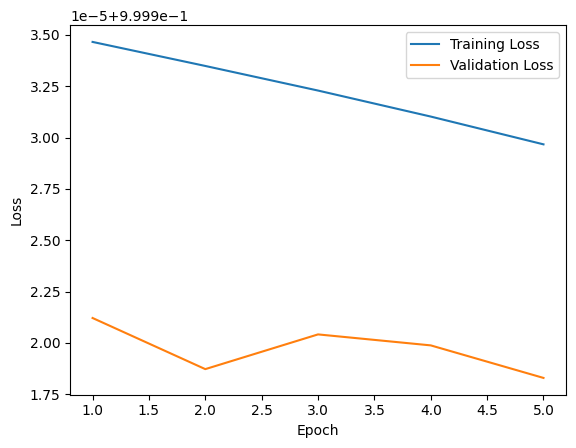

In [ ]:
curr_model = MultiLabelNN(hidden_dims=HIDDEN_DIMS, output_dim=len(protein_function_unique_metadata))
data_loader = DataLoader(protein_embeddings_dataset_train, batch_size=128)
data_loader_val = DataLoader(protein_embeddings_dataset_val, batch_size=len(X_val_imputed))
trained_model_nn = train_model(curr_model, data_loader, data_loader_val, torch.tensor(label_metadata["pos_weights"]), num_epochs=5) # for the remaining models they are trained with epochs less due to GPU and time constraints, note that the only model we trained fully was the DNN (50 epochs saved as model_checkpoint_final.pth)

In [ ]:
PATH = "model_checkpoint_final_nn_5_epochs.pth"
torch.save(trained_model_nn.state_dict(), PATH)

In [49]:
PATH = "model_checkpoint_final.pth"
# state_dict = torch.load('model_checkpoint_final', map_location=device)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
curr_model = MultiLabelNN(hidden_dims=[256, 512, 1024, 2048], output_dim=len(protein_function_unique_metadata))
curr_model.load_state_dict(torch.load('model_checkpoint_final.pth', map_location=device))
curr_model = curr_model.to(device)

In [50]:
def predict_test(model, dataloader, device, chunk_size=1000):
    model.eval()
    preds = []
    batch_chunk = []
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            X = batch.to(device)
            logits = model(X)
            out = torch.sigmoid(logits).cpu()
            batch_chunk.append(out)
            if len(batch_chunk) == chunk_size:
                print(i)
                print(i*len(batch))
                preds.append(torch.cat(batch_chunk))
                batch_chunk = []
        if batch_chunk:
            preds.append(torch.cat(batch_chunk))
    return torch.cat(preds)

In [52]:
data_loader_test = DataLoader(protein_embeddings_dataset_test, batch_size=64)
y_preds = predict_test(curr_model, data_loader_test, 'cuda')
print("y_preds")


999
63936
y_preds


In [54]:
y_preds = torch.round(y_preds * 1000) / 1000 # round to 3 decimals

In [82]:
def write_cafa_predictions(entry_ids, y_preds, label_names, output_path):
    with open(output_path, "w") as f:
        i = 0
        for entry_id, pred_vec in zip(entry_ids, y_preds):
            i+= 1
            if not i % 50:
              print(i)
            pred_vec = np.round(pred_vec, 3)
            for term, score in zip(label_names, pred_vec):
                if score != 0:
                    f.write(f"{entry_id}\t{term}\t{score}\n")


## Predict first 8k for faster processing (220k rows which could have up to 26k terms)

In [84]:
print(len(X_test_entry_ids))

write_cafa_predictions(
    entry_ids=X_test_entry_ids[:8000],
    y_preds=y_preds[:8000],
    label_names=mlb.classes_,
    output_path="to_score_NN_test.tsv"
)

224309
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
5000
5050
5100
5150
5200
5250
5300
5350
5400
5450
5500
5550
5600
5650
5700
5750
5800
5850
5900
5950
6000
6050
6100
6150
6200
6250
6300
6350
6400
6450
6500
6550
6600
6650
6700
6750
6800
6850
6900
6950
7000
7050
7100
7150
7200
7250
7300
7350
7400
7450
7500
7550
7600
7650
7700
7750
7800
7850
7900
7950
8000


In [69]:
X_test_entry_ids[:5]

[-0.0322461121970114,
 -0.02378039685892039,
 0.0015767425732222673,
 -0.07845950261472881,
 -0.10855579475216487]

In [72]:
fasta_emb_df['EntryID']

,EntryID
0,P86164
1,P84910
2,P83012
3,P83246
4,P86133
...,...
82149,Q8WXI7
82150,Q9I7U4
82151,G4SLH0
82152,Q8WZ42


In [86]:
to_submit = pd.read_csv("to_score_NN_test.tsv", sep="\t", header=None)
to_submit.to_csv("/content/drive/MyDrive/to_score_NN_test.tsv", index=False, header=False, sep="\t")

26125
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
curr epoch 1/5] loss: 0.9999340516058698 val_loss 0.9999177287905013
Validation op 3 labels (best F1):
Label 53: F1 = 0.25
Label 33: F1 = 0.2
Label 2314: F1 = 0.18181818181818182
Validation Bottom 3 labels (worst F1):
Label 17402: F1 = 0.0
Label 17414: F1 = 0.0
Label 17413: F1 = 0.0
Validation average f1 score: 0.0005023625931415316
curr epoch 2/5] loss: 0.999925030997407 val_loss 0.9999031031880844
Validation op 3 labels (best F1):
Label 6: F1 = 0.29508196721311475
Label 750: F1 = 0.2857142857142857
Label 33: F1 = 0.23809523809523808
Validation Bottom 3 labels (worst F1):
Label 17401: F1 = 0.0
Label 17413: F1 = 0.0
Label 17412: F1 = 0.0
Validation average f1 score: 0.0005686419132241702
curr epoch 3/5] loss: 0.9998891031558613 val_loss 0.999836794616388
Validation op 3 labels (best F1):
Label 1903: F1 = 1.0
Label 2402: F1 = 1.0
Labe

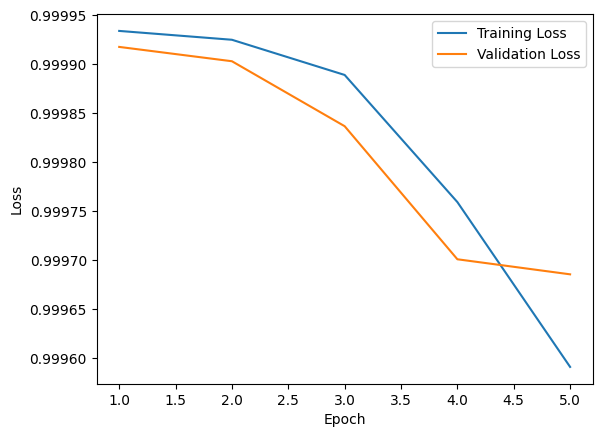

In [61]:

args_dict = {
    "heads": 1,
    "dropout": 0.1,
    "num_layers": 3, # More than 3 layers impacted performance negatively
    "model_type": "GraphSage"
}

label_metadata = obtain_label_metadata(y_train_transformed, output_dim)
data_loader = DataLoader(protein_embeddings_dataset_train, batch_size=128)
data_loader_val = DataLoader(protein_embeddings_dataset_val, batch_size=len(X_val_imputed))
curr_model = TwoTowerGNNAndNN(PCA_TARGET_DIM, 32, 64, output_dim,  G_data_dict['C'].x.size()[0], G_data_dict['F'].x.size()[0], G_data_dict['P'].x.size()[0], args_dict)
trained_model_two_tower_gsage_test = train_model_two_tower(curr_model, data_loader, data_loader_val, G_data_dict['C'], G_data_dict['F'], G_data_dict['P'], torch.tensor(label_metadata["pos_weights"][:output_dim]), num_epochs=5)

In [66]:
torch.save(trained_model_two_tower_gsage_test.state_dict(), "model_checkpoint_final_two_tower_gsage_test.pth")

26125
0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
curr epoch 1/5] loss: 0.9999341867736655 val_loss 0.9999185695310208
Validation op 3 labels (best F1):
Label 6: F1 = 0.39473684210526316
Label 33: F1 = 0.23076923076923078
Label 15714: F1 = 0.2222222222222222
Validation Bottom 3 labels (worst F1):
Label 17404: F1 = 0.0
Label 17416: F1 = 0.0
Label 17415: F1 = 0.0
Validation average f1 score: 0.00047702771659053267
curr epoch 2/5] loss: 0.9999258444391504 val_loss 0.99990550959341
Validation op 3 labels (best F1):
Label 13598: F1 = 0.6666666666666666
Label 6: F1 = 0.4444444444444444
Label 15714: F1 = 0.4
Validation Bottom 3 labels (worst F1):
Label 17403: F1 = 0.0
Label 17415: F1 = 0.0
Label 17414: F1 = 0.0
Validation average f1 score: 0.0005912123160499909
curr epoch 3/5] loss: 0.9998856267258879 val_loss 0.9998093045544406
Validation op 3 labels (best F1):
Label 9080: F1 = 1.0
Label 

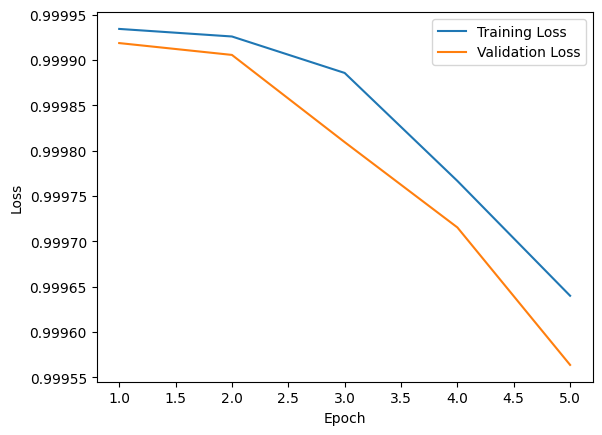

In [67]:
args_dict = {
    "heads": 2,
    "dropout": 0.1,
    "num_layers": 3, # More than 3 layers impacted performance negatively
    "model_type": "GAT"
}

label_metadata = obtain_label_metadata(y_train_transformed, output_dim)
data_loader = DataLoader(protein_embeddings_dataset_train, batch_size=128)
data_loader_val = DataLoader(protein_embeddings_dataset_val, batch_size=len(X_val_imputed))
curr_model = TwoTowerGNNAndNN(PCA_TARGET_DIM, 32, 64, output_dim,  G_data_dict['C'].x.size()[0], G_data_dict['F'].x.size()[0], G_data_dict['P'].x.size()[0], args_dict)
trained_model_two_tower_gat_test = train_model_two_tower(curr_model, data_loader, data_loader_val, G_data_dict['C'], G_data_dict['F'], G_data_dict['P'], torch.tensor(label_metadata["pos_weights"][:output_dim]), num_epochs=5)

In [68]:
torch.save(trained_model_two_tower_gat_test.state_dict(), "model_checkpoint_final_two_tower_gat_test.pth")

## This is the end of our notebook!
### This was a very fun project to work on, we tried a lot of approaches that didn't necessarily work at first, but over time we were able to reach a strong solution that allows to exploit the node embeddings within each subontology graph. We are planning to continue working on this project and hopefully perform well in the CAFA competition 😎

### A huge shoutout to all the staff and CS 224W TAs, we learned a lot.

# Best regards, Anirban, Daniel and Victor